#  Methods for Improving PINNs' Accuracy

As we have seen in the last lecture, implementing a PINNs model is relatively easy using Automatic Differentiation (AD), but in many cases it is very difficult to train it. One reason is that adding physics regularizer as a soft contstrain complicates the loss landscape thus results in a difficult optimization. There are some methods for improving the optimization process, we can split them into 4 sections. 

1. **Non-dimensionalization:** We talked about this last lecture. It is a very curicial method, and it must be the first step especially working with real data.
2. **Network Architecture:** Things like, Fourier features and enforcing hard boundary conditions. These methods are build into the networks architecture. We also talked about Fourier features, which encodes the input coordinates into high frequency signals and passes this information to the network. Hard boundary conditions on the other hand changes the output of the network by passing it through a function to enforce the boundary conditions. For example if a zero boundary condition, $u(x=0) = 0$, then we can multiply the output of the network with x. In this case the boundary conditions will always be enforced as at $x=0 \rightarrow$ $NN(x) \cdot x \overset{!}{=}0$. This is also a powerfull techique, however since the network output is scaled by x the derivaties of it must be defined accordingly. 
3. **Training Algorightm:** Methods such as adaptive weights, causal training, curriculum learning are all important methods to improve the training process. 
4. **Data Sampling**: The sampling strategy also plays a curicial role. Adaptive sampling strategies can make a big difference, especially when the problem in focus has steep gradients. 

In this lecture we will investigate some of these methods. 

## Curriculim Learning

To understand the effect of curriculum learning lets consider the 1d advection equation:

$$
\frac{\partial u}{\partial t} + v \frac{\partial u}{\partial x} = 0
$$

where  $u(x, t)$  is the solution, $v$ is the advection speed, $x$ is the spatial coordinate, and $t$ is time, with periodic conditions:

$$
u(x, 0) = sin(\frac{2\pi x}{L}) \quad \text{and} \quad u(0,t) = u(L, t)
$$

the analytical solution is:

$$
u(x, t) = sin(\frac{2\pi(x-\nu t)}{L})
$$

Firstly lets see how regular PINN will be with the problem. 

In [1]:
# importing the required libraries
import numpy as np
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

# Set random seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# A basic MLP architecture
class MLP(nn.Module):
    def __init__(self, arch, act):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(arch) - 1):
            layers.append(nn.Linear(arch[i], arch[i + 1]))
            if i < len(arch) - 2: 
                layers.append(act())
        self.model = nn.Sequential(*layers)

    def forward(self, inputs):
        return self.model(inputs)

# Constant for the problem
L = 2*np.pi # m

u_real_fun = lambda x, t, V: np.sin(2 * np.pi * (x - V*t) / L) # analytical solution

In [2]:
class pinn_advection(nn.Module):
    def __init__(self, net_u, loss_fn=torch.nn.MSELoss(), device='cpu'):
        super(pinn_advection, self).__init__()
        self.net_u = net_u.to(device)

        self.loss_fn = loss_fn
        self.device = device

    def net_u_forward(self, x, t):
        inputs = torch.cat((x, t), dim=1)
        u = self.net_u(inputs)
        return u
    # Calculates the loss for the PDE
    def loss_pde(self, x, t):
        u = self.net_u_forward(x, t)
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]

        pde_residual = u_t + self.V * u_x
        pde_loss = self.loss_fn(pde_residual, torch.zeros_like(pde_residual))
        return pde_loss
    
    # Calculates the loss for the initial condition u(x, 0) = sin(x)
    def loss_ic(self, x, t):
        u = self.net_u_forward(x, t)
        u_real = torch.sin(x)
        ic_loss = self.loss_fn(u, u_real)
        return ic_loss

    # Calculates the loss for the boundary conditions u(0, t) = u(L, t)
    def loss_bc(self, u_l_bc, u_r_bc):
        bc_loss = self.loss_fn(u_l_bc, u_r_bc)
        return bc_loss
    
    def pinn_loss(self):
        self.optimizer.zero_grad()

        x_dom = self.domain_points[:, 0:1].to(self.device).requires_grad_(True)
        t_dom = self.domain_points[:, 1:2].to(self.device).requires_grad_(True)
        x_ic = self.ic_points[:, 0:1].to(self.device).requires_grad_(True)
        t_ic = self.ic_points[:, 1:2].to(self.device).requires_grad_(True)
        x_bc_left = self.bc_left_points[:, 0:1].to(self.device).requires_grad_(True)
        t_bc_left = self.bc_left_points[:, 1:2].to(self.device).requires_grad_(True)
        x_bc_right = self.bc_right_points[:, 0:1].to(self.device).requires_grad_(True)
        t_bc_right = self.bc_right_points[:, 1:2].to(self.device).requires_grad_(True)

        # Calculate losses
        pde_loss = self.loss_pde(x_dom, t_dom)
        ic_loss = self.loss_ic(x_ic, t_ic)

        u_l_bc = self.net_u_forward(x_bc_left, t_bc_left)
        u_r_bc = self.net_u_forward(x_bc_right, t_bc_right)
        bc_loss = self.loss_bc(u_l_bc, u_r_bc)

        total_loss = pde_loss +  ic_loss +  bc_loss # combine losses
        total_loss.backward() # backpropagate the total loss

        # log the losses 
        if self.iter % self.log_interval == 0:
            print(f'[{self.optimizer_name}]: Iteration {self.iter}, Total loss: {total_loss.item():.3e}, PDE Loss: {pde_loss.item():.3e}, IC Loss: {ic_loss.item():.3e}, BC Loss: {bc_loss.item():.3e}, V: {self.V:.3f}')
        self.iter += 1
        return total_loss

    def train_net(self, domain_points, ic_points, bc_left_points, bc_right_points, epochs, optimizer=torch.optim.Adam, log_interval=100, V=1.0):
        self.V = V
        self.epochs = epochs
        self.log_interval = log_interval
        self.domain_points = domain_points.to(self.device)
        self.ic_points = ic_points.to(self.device)
        self.bc_left_points = bc_left_points.to(self.device)
        self.bc_right_points = bc_right_points.to(self.device) 
        self.net_u.train()

        self.iter = 0

        if optimizer is torch.optim.LBFGS:
            self.optimizer_name = 'LBFGS'
            self.optimizer = optimizer(self.net_u.parameters(), lr=1, max_iter=epochs, max_eval=None, history_size=100, tolerance_grad=1e-8, tolerance_change=1e-8, line_search_fn='strong_wolfe')
            self.optimizer.step(self.pinn_loss)

        else:
            self.optimizer = optimizer(self.net_u.parameters(), lr=1e-3)
            self.optimizer_name = 'Adam'
            for epoch in range(epochs):
                self.pinn_loss()
                self.optimizer.step()

    # Predict the solution at given points x and t
    def predict(self, x, t):
        self.net_u.eval()
        with torch.no_grad():
            x = x.to(self.device)
            t = t.to(self.device)
            return self.net_u_forward(x, t).cpu().numpy()
    
    # Evaluate the model on a grid of points and compare with the analytical solution
    def evaluate(self, num_x=100, num_t=100, V=None):

        self.net_u.eval()

        # Prepare testing grid
        x_test = torch.linspace(0, L, num_x).reshape(-1, 1).to(self.device)
        t_test = torch.linspace(0, 1, num_t).reshape(-1, 1).to(self.device)
        x_grid, t_grid = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')
        x_grid_flat = x_grid.reshape(-1, 1)
        t_grid_flat = t_grid.reshape(-1, 1)

        # Predict using the trained model
        u_pred = self.predict(x_grid_flat, t_grid_flat)

        # Analytical solution
        u_analytical = u_real_fun(x_grid_flat.cpu().numpy(), t_grid_flat.cpu().numpy(), V).reshape(num_x, num_t)

        # Reshape for comparison
        u_pred = u_pred.reshape(num_x, num_t)

        # Calculate errors
        diff = np.abs(u_pred - u_analytical)
        
        # Calculate accuracy as 1 - normalized RMSE
        acc = 1 - np.sqrt(np.mean(diff ** 2))

        # Plot prediction vs analytical solution
        plt.figure(figsize=(20, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(u_pred, aspect='auto', origin='lower', extent=[0.0, 1.0, 0.0, L], cmap="rainbow")
        plt.colorbar()
        plt.title("PINN Prediction")
        plt.xlabel("t")
        plt.ylabel("x")

        plt.subplot(1, 3, 2)
        plt.imshow(u_analytical, aspect='auto', origin='lower', extent=[0, 1, 0, L], cmap="rainbow")
        plt.colorbar()
        plt.title("Analytical Solution")
        plt.xlabel("t")
        plt.ylabel("x")

        plt.subplot(1, 3, 3)
        plt.imshow(diff, aspect='auto', origin='lower', extent=[0.0, 1.0, 0.0, L], cmap="binary")
        plt.colorbar()
        plt.title(f"Absolute Error, Accuracy: {acc:.4f}")
        plt.xlabel("t")
        plt.ylabel("x")

        plt.tight_layout()

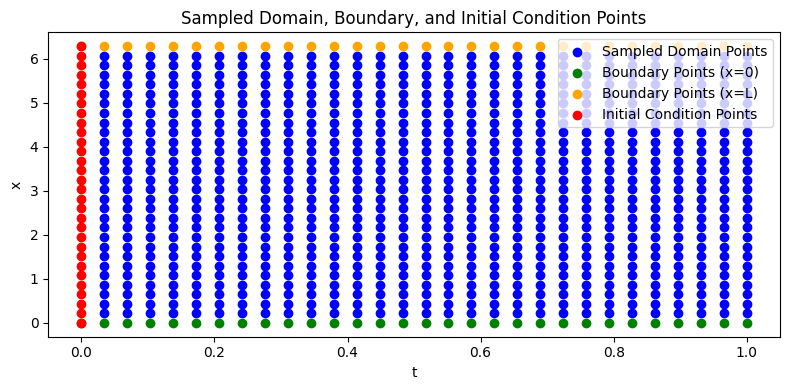

In [3]:
num_x = 30  # Number of points in the x direction
num_t = 30  # Number of points in the t direction

x_lin = torch.linspace(0, L, num_x).reshape(-1, 1)  # x grid
t_lin = torch.linspace(0, 1, num_t).reshape(-1, 1)  # t grid

x_lin_domain = x_lin[1:-1]  # Exclude the boundaries for collocation points
t_lin_domain = t_lin[1:]    # Exclude the initial condition for collocation points

# create a grid of points in the domain
x_grid, t_grid = torch.meshgrid(x_lin_domain.squeeze(), t_lin_domain.squeeze(), indexing='ij')
x_grid_flat = x_grid.reshape(-1, 1)
t_grid_flat = t_grid.reshape(-1, 1)

dom_points = torch.cat((x_grid_flat, t_grid_flat), dim=1)

# Generate boundary condition points
bc_l_pts = torch.cat((torch.zeros_like(t_lin), t_lin), dim=1)  # Boundary at x=0, num_t points
bc_r_pts = torch.cat((torch.full_like(t_lin, L), t_lin), dim=1)  # Boundary at x=L

# Generate initial condition points
ic_pts = torch.cat((x_lin, torch.zeros_like(x_lin)), dim=1) # num_x points

plt.figure(figsize=(8, 4))
plt.scatter(dom_points[:, 1].cpu().numpy(), dom_points[:, 0].cpu().numpy(), color='blue', label='Sampled Domain Points')
plt.scatter(bc_l_pts[:, 1].cpu().numpy(), bc_l_pts[:, 0].cpu().numpy(), color='green', label='Boundary Points (x=0)')
plt.scatter(bc_r_pts[:, 1].cpu().numpy(), bc_r_pts[:, 0].cpu().numpy(), color='orange', label='Boundary Points (x=L)')
plt.scatter(ic_pts[:, 1].cpu().numpy(), ic_pts[:, 0].cpu().numpy(), color='red', label='Initial Condition Points')
plt.title('Sampled Domain, Boundary, and Initial Condition Points')
plt.xlabel('t')
plt.ylabel('x')
plt.tight_layout()
plt.legend()

[Adam]: Iteration 0, Total loss: 4.940e-01, PDE Loss: 2.441e-04, IC Loss: 4.906e-01, BC Loss: 3.205e-03, V: 1.000
[Adam]: Iteration 10000, Total loss: 2.865e-06, PDE Loss: 1.391e-06, IC Loss: 1.376e-06, BC Loss: 9.798e-08, V: 1.000
[Adam]: Iteration 20000, Total loss: 2.870e-06, PDE Loss: 7.435e-07, IC Loss: 1.826e-06, BC Loss: 3.004e-07, V: 1.000
[Adam]: Iteration 30000, Total loss: 2.787e-06, PDE Loss: 4.420e-07, IC Loss: 1.817e-06, BC Loss: 5.284e-07, V: 1.000


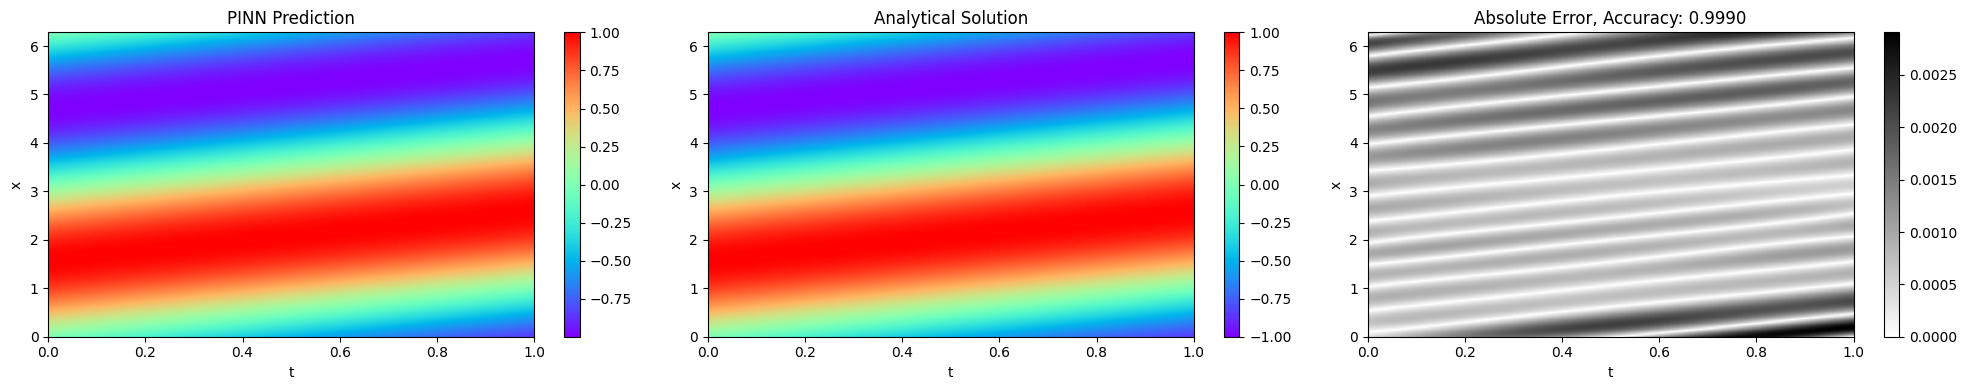

In [4]:
arch = [2] + [32] * 4 + [1]  # Input layer, hidden layers, output layer
act = nn.Tanh  # Activation function
net_u = MLP(arch, act)

model = pinn_advection(net_u, device=device)

V_train = 1

model.train_net(domain_points=dom_points, ic_points=ic_pts, bc_left_points=bc_l_pts, bc_right_points=bc_r_pts, epochs=40000, optimizer=torch.optim.Adam, log_interval=10000, V=V_train)
model.evaluate(num_x=256, num_t=100, V=V_train)

Nice, vanilla PINN can predict learn the advection equation at $\nu = 1$, but can it also learn if the advection speed increases? Lets try it again for $\nu = 30$

[Adam]: Iteration 0, Total loss: 5.038e-01, PDE Loss: 1.541e-02, IC Loss: 4.884e-01, BC Loss: 4.573e-05, V: 30.000
[Adam]: Iteration 10000, Total loss: 1.698e-05, PDE Loss: 9.135e-06, IC Loss: 4.736e-06, BC Loss: 3.107e-06, V: 30.000
[Adam]: Iteration 20000, Total loss: 5.243e-04, PDE Loss: 2.635e-04, IC Loss: 2.239e-04, BC Loss: 3.689e-05, V: 30.000
[Adam]: Iteration 30000, Total loss: 2.346e-06, PDE Loss: 6.166e-07, IC Loss: 1.690e-06, BC Loss: 3.845e-08, V: 30.000


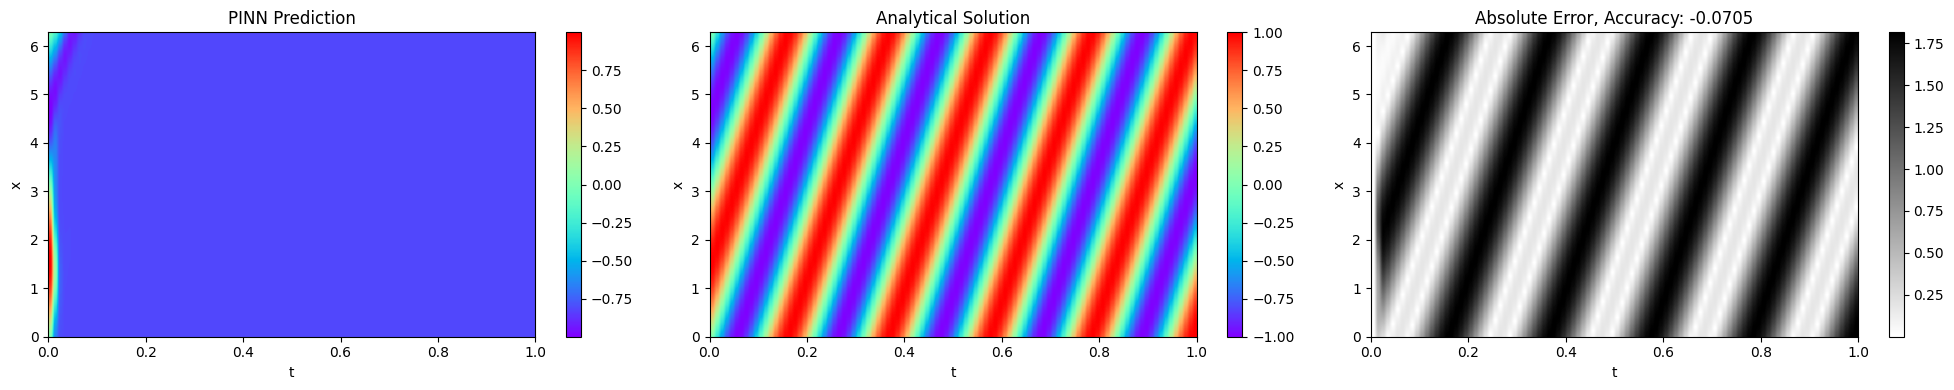

In [5]:
arch = [2] + [32] * 4 + [1]  # Input layer, hidden layers, output layer
act = nn.Tanh  # Activation function
net_u = MLP(arch, act)

model = pinn_advection(net_u, device=device)

V_train = 30

model.train_net(domain_points=dom_points, ic_points=ic_pts, bc_left_points=bc_l_pts, bc_right_points=bc_r_pts, epochs=40000, optimizer=torch.optim.Adam, log_interval=10000, V=V_train)
model.evaluate(num_x=256, num_t=100, V=V_train)

Yeaah, it seems to fail for advection larger speed. You can probably see why by looking at the real solution. The frequency of the solution increases, thus regular pinns fail to learn the high frequency relations. Fourier features most likely would help here, but we can also use some transfer learning to improve the optimization. This is where curriculum training comes to play. In curriculum training we can basically train the network first with smallar advection speed then increase the speed as we continue to train further. It is straightforward to implement. The `pinn_advection` class is alredy build that you can pass V values into training. So we just create a loop and train the network from $\nu = 0.1$ to $\nu = 30$. 

[Adam]: Iteration 0, Total loss: 4.993e-01, PDE Loss: 1.375e-04, IC Loss: 4.913e-01, BC Loss: 7.781e-03, V: 0.100
[Adam]: Iteration 1000, Total loss: 1.071e-03, PDE Loss: 4.900e-04, IC Loss: 5.182e-04, BC Loss: 6.309e-05, V: 0.100
[Adam]: Iteration 2000, Total loss: 6.259e-03, PDE Loss: 1.418e-04, IC Loss: 1.703e-03, BC Loss: 4.415e-03, V: 0.100
[Adam]: Iteration 3000, Total loss: 1.198e-04, PDE Loss: 6.479e-05, IC Loss: 4.202e-05, BC Loss: 1.298e-05, V: 0.100
[Adam]: Iteration 0, Total loss: 5.345e+00, PDE Loss: 5.345e+00, IC Loss: 1.940e-05, BC Loss: 7.541e-06, V: 3.422
[Adam]: Iteration 1000, Total loss: 1.716e-01, PDE Loss: 6.613e-02, IC Loss: 8.874e-02, BC Loss: 1.672e-02, V: 3.422
[Adam]: Iteration 2000, Total loss: 7.963e-03, PDE Loss: 3.976e-03, IC Loss: 1.858e-03, BC Loss: 2.129e-03, V: 3.422
[Adam]: Iteration 3000, Total loss: 2.222e-03, PDE Loss: 1.715e-03, IC Loss: 3.218e-04, BC Loss: 1.854e-04, V: 3.422
[Adam]: Iteration 0, Total loss: 5.475e+00, PDE Loss: 5.475e+00, IC Lo

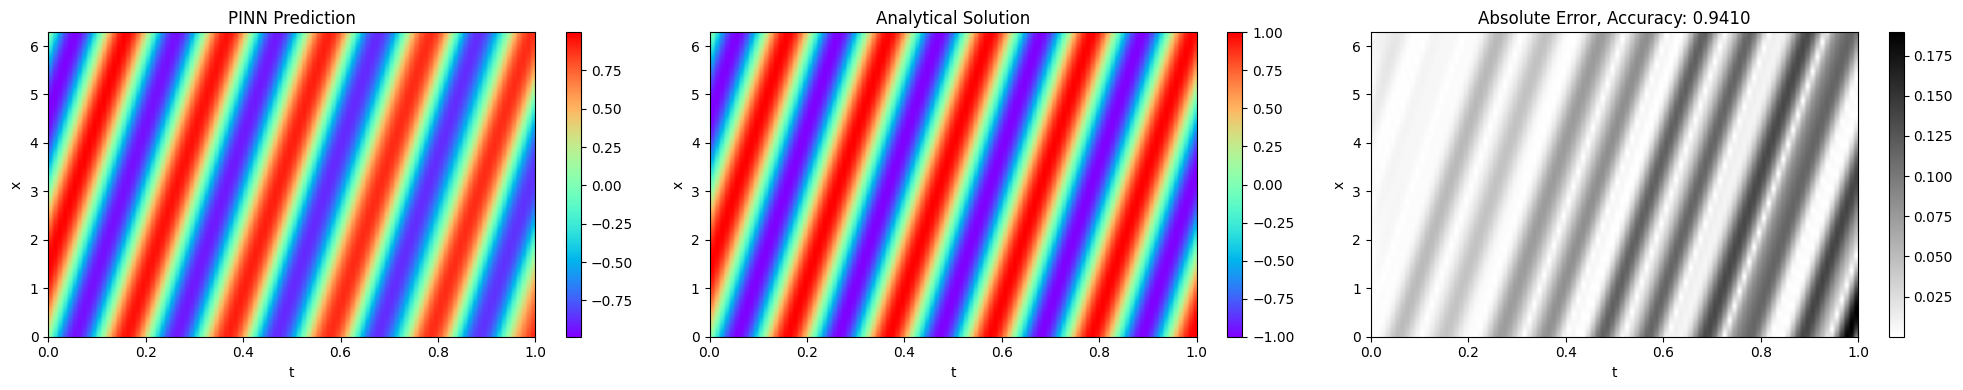

In [6]:
arch = [2] + [32] * 4 + [1]  # Input layer, hidden layers, output layer
act = nn.Tanh  # Activation function
net_u = MLP(arch, act)

model = pinn_advection(net_u, device=device)

V_0 = 0.1  # Initial value of V
Vcurr = V_0  # Current value of V
V_last = 30  # Last value of V
steps = 10
# we define the V_current as a linear interpolation between V_0 and V_last. So we train 10 steps, 4000 epochs each
for i in range(steps):
    V_current = V_0 + i * (V_last - V_0) / (steps-1)  # Increment V gradually
    model.train_net(domain_points=dom_points, ic_points=ic_pts, bc_left_points=bc_l_pts, bc_right_points=bc_r_pts, epochs=4000, optimizer=torch.optim.Adam, log_interval=1000, V=V_current)
model.evaluate(num_x=256, num_t=100, V=V_last)

Leveraging transfer learning in such ways can drastically increase the model's ability to learn. 

## Sampling Strategy

It has been studied that the sampling strategy plays an important role in training PINNs. The samples used for the calculation of PDE residuals can be sampled non-adaptive or adaptive. So far we have only handled non-adaptive samplings, more specifically uniform grid grid and random samples. Non-adaptive methods are simple to implement, but can lack the training accuracy for complex problems. 


Strategies such as residual-based adaptive refining (RAR) or gradient-based adaptive refining (GAR) can significantly increase the accuracy especially when the number of residual points are small. Also the problems with steep gradients are better trained using with adaptive sampling methods, as the model can resample more points of the region with steep gradients. 

Lets investigate some these using the diffusion equation: 

$$\frac{\partial u}{\partial t} - \frac{\partial^2 u}{\partial x^2} + e^{-t}(\sin(\pi x) - \pi^2\sin(\pi x)) = 0$$
$$u(x, 0) = sin(\pi x)\quad x\in[-1, 1]$$
$$u(-1, t) = u(1, t) = 0, \quad t\in[0,1]$$

exact solution is:

$$u(x, t) = \sin(\pi x)e^{-t}$$

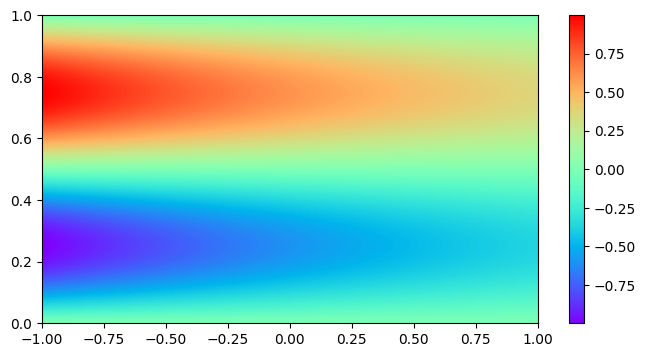

In [7]:
u_diffusion = lambda x, t: np.sin(np.pi * x) * np.exp(-t)

# Plot the analytical solution for the diffusion equation
x_lin = torch.linspace(-1, 1, 200).reshape(-1, 1)  # x grid
t_lin = torch.linspace(0, 1, 200).reshape(-1, 1)  # t grid
x_grid, t_grid = torch.meshgrid(x_lin.squeeze(), t_lin.squeeze(), indexing='ij')
x_grid_flat = x_grid.reshape(-1, 1)
t_grid_flat = t_grid.reshape(-1, 1)
u_analytical = u_diffusion(x_grid_flat.cpu().numpy(), t_grid_flat.cpu().numpy()).reshape(200, 200)
plt.figure(figsize=(8, 4))
plt.imshow(u_analytical, aspect='auto', origin='lower', extent=[-1, 1, 0, 1], cmap="rainbow")
plt.colorbar()

Here we are introducing some sampling methods, uniform grid latih hypercube and random samples. 

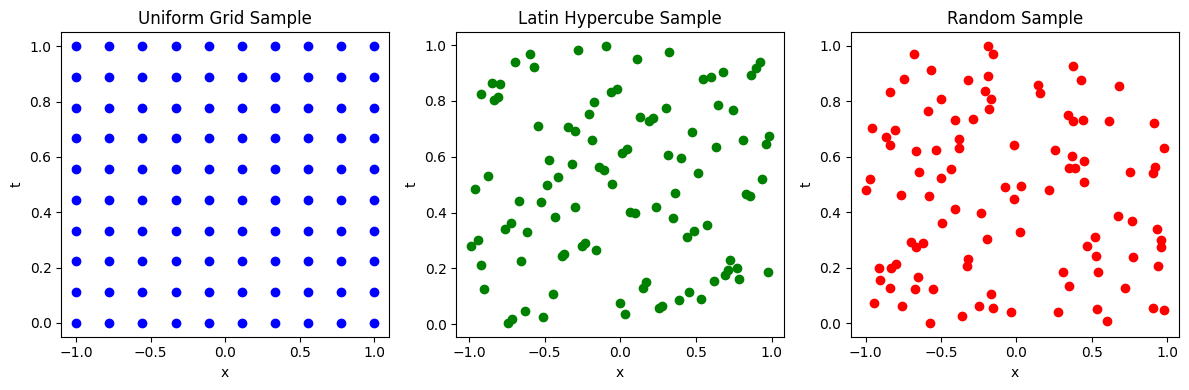

In [8]:
from scipy.stats.qmc import LatinHypercube

def generate_grid_sample(n_samples, spans):

    n_dims = len(spans)
    nums_each_dim = int(np.ceil(n_samples**(1/n_dims)))  # Calculate points per dimension
    
    grids = [torch.linspace(span[0], span[1], nums_each_dim) for span in spans]
    grid = torch.meshgrid(*grids, indexing='ij')
    grid_points = torch.stack([g.flatten() for g in grid], dim=1)
    
    # Take only the first n_samples points
    return grid_points[:n_samples]

def generate_lhs_sample(nums_each_dim, spans):

    lhs = LatinHypercube(d=len(spans))
    lhs_samples = lhs.random(n=nums_each_dim)  # shape: (nums_each_dim, d)
    # Scale each column to the corresponding span
    for i, span in enumerate(spans):
        lhs_samples[:, i] = span[0] + (span[1] - span[0]) * lhs_samples[:, i]
    return torch.tensor(lhs_samples, dtype=torch.float32)

def generate_random_sample(nums_each_dim, spans):

    # Generate a (nums_each_dim, len(spans)) tensor of random numbers in [0, 1)
    rand = torch.rand(nums_each_dim, len(spans))
    # Scale each column to the corresponding span
    for i, span in enumerate(spans):
        rand[:, i] = rand[:, i] * (span[1] - span[0]) + span[0]
    return rand

# generate data using the three methods
num_points = 100
spans = [(-1, 1), (0, 1)]  # spans for x and t
flat_grid_sample = generate_grid_sample(num_points, spans)
lhs_sample = generate_lhs_sample(num_points, spans)
random_sample = generate_random_sample(num_points, spans)

# Plot the samples
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(flat_grid_sample[:, 0], flat_grid_sample[:, 1], color='blue', label='Uniform Grid Sample')
plt.title('Uniform Grid Sample')
plt.xlabel('x')
plt.ylabel('t')
plt.subplot(1, 3, 2)
plt.scatter(lhs_sample[:, 0], lhs_sample[:, 1], color='green', label='LHS Sample')
plt.title('Latin Hypercube Sample')
plt.xlabel('x')
plt.ylabel('t')
plt.subplot(1, 3, 3)
plt.scatter(random_sample[:, 0], random_sample[:, 1], color='red', label='Random Sample')
plt.title('Random Sample')
plt.xlabel('x')
plt.ylabel('t')
plt.tight_layout()


Then we can build the PINN model for the diffusion equation as before. Here I've already implemented some extra class methods for sampling strategies. 

In [9]:
class pinn_diffusion(nn.Module):
    def __init__(self, net_u, loss_fn=torch.nn.MSELoss(), device='cpu'):
        super(pinn_diffusion, self).__init__()
        self.net_u = net_u.to(device)
        self.adaptive_points = None  # Initialize adaptive points

        self.loss_fn = loss_fn
        self.device = device

    def net_u_forward(self, x, t):
        inputs = torch.cat((x, t), dim=1)
        u = self.net_u(inputs)
        return u
    
    def pde_residual(self, x, t):
        u = self.net_u_forward(x, t)
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]

        pde_residual = u_t - u_xx - torch.exp(-t) * (-torch.sin(torch.pi * x) + torch.pi**2 *torch.sin(torch.pi * x))
        return pde_residual
    
    # Calculates the loss for the PDE
    def loss_pde(self, x, t):
        pde_residual = self.pde_residual(x, t)
        pde_loss = self.loss_fn(pde_residual, torch.zeros_like(pde_residual))
        return pde_loss
    
    # Calculates the loss for the initial condition u(x, 0) = sin(pi * x) + 1/2 * sin(4 * pi * x)
    def loss_ic(self, x, t):
        u = self.net_u_forward(x, t)
        # u_real = torch.sin(np.pi * x) + 1/2 * torch.sin(4 * np.pi * x)
        u_real = torch.sin(torch.pi * x)
        ic_loss = self.loss_fn(u, u_real)
        return ic_loss

    # Calculates the loss for the boundary conditions u(0, t) = u(1, t) = 0
    def loss_bc(self, x, t):
        u = self.net_u_forward(x, t)
        bc_loss = self.loss_fn(u, torch.zeros_like(u))
        return bc_loss
    
    def pinn_loss(self):
        self.optimizer.zero_grad()

        x_dom = self.domain_points[:, 0:1].to(self.device).requires_grad_(True)
        t_dom = self.domain_points[:, 1:2].to(self.device).requires_grad_(True)
        x_ic = self.ic_points[:, 0:1].to(self.device).requires_grad_(True)
        t_ic = self.ic_points[:, 1:2].to(self.device).requires_grad_(True)
        x_l_bc = self.bc_l_points[:, 0:1].to(self.device).requires_grad_(True)
        t_l_bc = self.bc_l_points[:, 1:2].to(self.device).requires_grad_(True)
        x_r_bc = self.bc_r_points[:, 0:1].to(self.device).requires_grad_(True)
        t_r_bc = self.bc_r_points[:, 1:2].to(self.device).requires_grad_(True)

        # Calculate losses
        pde_loss = self.loss_pde(x_dom, t_dom)
        ic_loss = self.loss_ic(x_ic, t_ic)
        bc_l_loss = self.loss_bc(x_l_bc, t_l_bc)
        bc_r_loss = self.loss_bc(x_r_bc, t_r_bc)

        total_loss = pde_loss + ic_loss + bc_l_loss + bc_r_loss
        total_loss.backward() # backpropagate the total loss

        # log the losses 
        if self.iter % self.log_interval == 0:
            print(f'[{self.optimizer_name}]: Iteration {self.iter}, Total loss: {total_loss.item():.3e}, PDE Loss: {pde_loss.item():.3e}, IC Loss: {ic_loss.item():.3e}, BC Left Loss: {bc_l_loss.item():.3e}, BC Right Loss: {bc_r_loss.item():.3e}')
        self.iter += 1
        return total_loss

    def train_net(self, domain_points, ic_points, bc_l_points, bc_r_points, epochs, optimizer=torch.optim.Adam, log_interval=100):
        self.epochs = epochs
        self.domain_points = domain_points
        self.ic_points = ic_points
        self.bc_l_points = bc_l_points
        self.bc_r_points = bc_r_points

        self.net_u.train()
        self.iter = 0
        self.log_interval = log_interval
        if optimizer is torch.optim.LBFGS:
            self.optimizer_name = 'LBFGS'
            self.optimizer = optimizer(self.net_u.parameters(), lr=1, max_iter=epochs, max_eval=None, history_size=100, tolerance_grad=1e-8, tolerance_change=1e-8, line_search_fn='strong_wolfe')
            self.optimizer.step(self.pinn_loss)
        else:
            self.optimizer = optimizer(self.net_u.parameters(), lr=1e-3)
            self.optimizer_name = 'Adam'
            for epoch in range(epochs):
                self.pinn_loss()
                self.optimizer.step()

    def adaptive_sampling(self, num_points, base_grid_points, method):
        base_grid_x = base_grid_points[:, 0:1].to(self.device).requires_grad_(True)
        base_grid_t = base_grid_points[:, 1:2].to(self.device).requires_grad_(True)

        self.eval()
        if method == 'gar':
            u = self.net_u_forward(base_grid_x, base_grid_t)

            # calculate gradients to see the steepest prediction points
            u_x = torch.autograd.grad(u, base_grid_x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
            u_t = torch.autograd.grad(u, base_grid_t, torch.ones_like(u), create_graph=True, retain_graph=True)[0]

            _, idx_u_x = torch.topk(u_x.squeeze().abs(), num_points)
            _, idx_u_t = torch.topk(u_t.squeeze().abs(), num_points)

            idx = torch.cat((idx_u_x, idx_u_t), dim=0)
            idx = torch.unique(idx)  # Ensure unique indice

        if method == 'rar':
            pde_residual = self.pde_residual(base_grid_x, base_grid_t)
            _, idx = torch.topk(pde_residual.squeeze().abs(), num_points)
        
        self.adaptive_points = base_grid_points[idx, :]
        return self.adaptive_points.to(self.device)

    def predict(self, x, t):
        self.net_u.eval()
        with torch.no_grad():
            x = x.to(self.device)
            t = t.to(self.device)
            return self.net_u_forward(x, t).cpu().numpy()
    
    def evaluate(self, num_x=100, num_t=100):

        self.net_u.eval()

        # Prepare testing grid
        x_test = torch.linspace(-1, 1, num_x).reshape(-1, 1).to(self.device)
        t_test = torch.linspace(0, 1, num_t).reshape(-1, 1).to(self.device)
        x_grid, t_grid = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')
        x_grid_flat = x_grid.reshape(-1, 1)
        t_grid_flat = t_grid.reshape(-1, 1)

        # Predict using the trained model
        u_pred = self.predict(x_grid_flat, t_grid_flat)
        # Analytical solution
        ref_sol = u_diffusion(x_grid_flat.cpu().numpy(), t_grid_flat.cpu().numpy()).reshape(num_x, num_t)

        # Reshape for comparison
        sol = u_pred.reshape(num_x, num_t)

        # Calculate errors
        diff = np.abs(sol - ref_sol)

        # calculate L2 relative error
        L2_norm = np.linalg.norm(ref_sol)
        L2_rel_error = diff / L2_norm
        mean_relative_error = np.mean(L2_rel_error)
        print(f'Mean Relative Error: {mean_relative_error:.4f}')

        # accuracy 1 - normalized RMSE
        acc = 1 - np.sqrt(np.mean(diff ** 2))

        fig, axes = plt.subplots(1, 4, figsize=(20, 4))
        axes = axes.flatten()

        axes[0].imshow(sol, aspect='auto', origin='lower', extent=[0.0, 1.0, 0.0, L], cmap="rainbow")
        axes[0].set_title("PINN Prediction")

        axes[1].imshow(ref_sol, aspect='auto', origin='lower', extent=[0, 1, 0, L], cmap="rainbow")
        axes[1].set_title("Reference Solution")

        axes[2].imshow(diff, aspect='auto', origin='lower', extent=[0.0, 1.0, 0.0, L], cmap="binary")
        axes[2].set_title(f"Absolute Error, Accuracy: {acc:.3f}")

        axes[3].scatter(self.domain_points[:, 1], self.domain_points[:, 0], c="steelblue", label="collcations")
        if self.adaptive_points is not None:
            axes[3].scatter(self.adaptive_points[:, 1], self.adaptive_points[:, 0], c="yellowgreen", label="adaptive points", marker="x")
        axes[3].scatter(self.bc_l_points[:, 1], self.bc_l_points[:, 0], c="crimson")
        axes[3].scatter(self.bc_r_points[:, 1], self.bc_r_points[:, 0], c="crimson")
        axes[3].scatter(self.ic_points[:, 1], self.ic_points[:, 0], c="orange")
        axes[3].set(xlim=[0, 1], ylim=[-1, 1], xlabel="t" + 's', ylabel="x" + 'm',)
        axes[3].legend(bbox_to_anchor=(1.02, 1.00), loc='upper left', borderaxespad=0.)
        axes[3].set_title("Sampling Points")

        plt.colorbar(axes[0].images[0], ax=axes[0])
        plt.colorbar(axes[1].images[0], ax=axes[1])
        plt.colorbar(axes[2].images[0], ax=axes[2])
        plt.tight_layout()

We define a Sampler class, to hold the functions for sampling. We can use this class later for sampling the residual, bc and ic points during training.

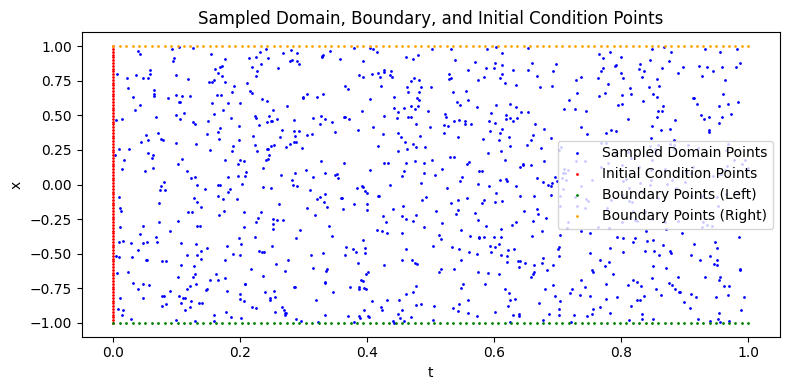

In [10]:
class Sampler:
    def __init__(self, spans):
        self.spans = spans

    def sample(self, num_dom, num_ic, num_bc, method=['grid', 'grid', 'grid'], device=torch.device('cpu')):

        dom_points = self.sample_domain_points(num_dom, method[0], device)
        ic_points = self.sample_ic_points(num_ic, method[1])
        bc_left_points, bc_right_points = self.sample_bc_points(num_bc, method[2])

        return dom_points, ic_points, bc_left_points, bc_right_points
    
    def sample_domain_points(self, num_points, method='grid', device=torch.device('cpu')):

        # remove the first and last points from the spans to avoid boundary points
        spans = [(span[0] + 1e-5, span[1] - 1e-5) for span in self.spans]

        if method == 'grid':
            return generate_grid_sample(num_points, spans).to(device)
        elif method == 'lhs':
            return generate_lhs_sample(num_points, spans).to(device)
        elif method == 'random':
            return generate_random_sample(num_points, spans).to(device)
        else:
            raise ValueError("Method must be 'grid', 'lhs', or 'random'.")
        
    def sample_ic_points(self, num_points, method='grid', device=torch.device('cpu')):
        if method == 'grid':
            x = torch.linspace(self.spans[0][0], self.spans[0][1], num_points).reshape(-1, 1)
            t = torch.zeros_like(x)
            return torch.cat((x, t), dim=1).to(device)
        elif method == 'lhs':
            x = generate_lhs_sample(num_points, [(self.spans[0][0], self.spans[0][1])])
            t = torch.zeros_like(x[:, 0:1])
            return torch.cat((x, t), dim=1).to(device)
        elif method == 'random':
            x = generate_random_sample(num_points, [(self.spans[0][0], self.spans[0][1])])
            t = torch.zeros_like(x[:, 0:1])
            return torch.cat((x, t), dim=1).to(device)
        else:
            raise ValueError("Method must be 'grid', 'lhs', or 'random'.")
    
    def sample_bc_points(self, num_points, method='grid', device=torch.device('cpu')):
        if method == 'grid':
            t = torch.linspace(self.spans[1][0], self.spans[1][1], num_points).reshape(-1, 1)
            x_left = torch.full_like(t, self.spans[0][0])
            x_right = torch.full_like(t, self.spans[0][1])
            bc_left_points = torch.cat((x_left, t), dim=1)
            bc_right_points = torch.cat((x_right, t), dim=1)

            return bc_left_points.to(device), bc_right_points.to(device)
        elif method == 'lhs':
            t = generate_lhs_sample(num_points, [(self.spans[1][0], self.spans[1][1])])
            x_left = torch.full_like(t[:, 0:1], self.spans[0][0])
            x_right = torch.full_like(t[:, 0:1], self.spans[0][1])
            bc_left_points = torch.cat((x_left, t), dim=1)
            bc_right_points = torch.cat((x_right, t), dim=1)

            return bc_left_points.to(device), bc_right_points.to(device)
        elif method == 'random':
            t = generate_random_sample(num_points, [(self.spans[1][0], self.spans[1][1])])
            x_left = torch.full_like(t[:, 0:1], self.spans[0][0])
            x_right = torch.full_like(t[:, 0:1], self.spans[0][1])
            bc_left_points = torch.cat((x_left, t), dim=1)
            bc_right_points = torch.cat((x_right, t), dim=1)

            return bc_left_points.to(device), bc_right_points.to(device)


sampler = Sampler(spans=[(-1, 1), (0, 1)])
dom_points, ic_points, bc_left_points, bc_right_points = sampler.sample(num_dom=1000, num_ic=100, num_bc=100, method=['random', 'grid', 'grid'])
plt.figure(figsize=(8, 4))
plt.scatter(dom_points[:, 1].cpu().numpy(), dom_points[:, 0].cpu().numpy(), s=1, color='blue', label='Sampled Domain Points')
plt.scatter(ic_points[:, 1].cpu().numpy(), ic_points[:, 0].cpu().numpy(), s=1, color='red', label='Initial Condition Points')
plt.scatter(bc_left_points[:, 1].cpu().numpy(), bc_left_points[:, 0].cpu().numpy(), s=1, color='green', label='Boundary Points (Left)')
plt.scatter(bc_right_points[:, 1].cpu().numpy(), bc_right_points[:, 0].cpu().numpy(), s=1, color='orange', label='Boundary Points (Right)')
plt.title('Sampled Domain, Boundary, and Initial Condition Points')
plt.xlabel('t')
plt.ylabel('x')
plt.tight_layout()
plt.legend()

First lets train the model with fixed samples. Change the sampling_methods in the following cell and observe the difference. There is minor difference as the problem is a rather easier one.

[Adam]: Iteration 0, Total loss: 1.396e+01, PDE Loss: 1.349e+01, IC Loss: 4.386e-01, BC Left Loss: 2.891e-03, BC Right Loss: 2.574e-02
[Adam]: Iteration 1000, Total loss: 2.123e-03, PDE Loss: 1.053e-03, IC Loss: 3.914e-04, BC Left Loss: 5.532e-04, BC Right Loss: 1.254e-04
[Adam]: Iteration 2000, Total loss: 3.298e-04, PDE Loss: 2.275e-04, IC Loss: 1.283e-05, BC Left Loss: 7.468e-05, BC Right Loss: 1.478e-05
[Adam]: Iteration 3000, Total loss: 1.492e-04, PDE Loss: 1.268e-04, IC Loss: 2.031e-06, BC Left Loss: 1.439e-05, BC Right Loss: 5.936e-06
[Adam]: Iteration 4000, Total loss: 4.250e-05, PDE Loss: 2.997e-05, IC Loss: 3.888e-07, BC Left Loss: 7.551e-06, BC Right Loss: 4.591e-06
[Adam]: Iteration 5000, Total loss: 2.093e-05, PDE Loss: 1.100e-05, IC Loss: 5.570e-08, BC Left Loss: 6.360e-06, BC Right Loss: 3.520e-06
[Adam]: Iteration 6000, Total loss: 1.234e-05, PDE Loss: 4.708e-06, IC Loss: 2.705e-07, BC Left Loss: 5.493e-06, BC Right Loss: 1.873e-06
[Adam]: Iteration 7000, Total loss: 6

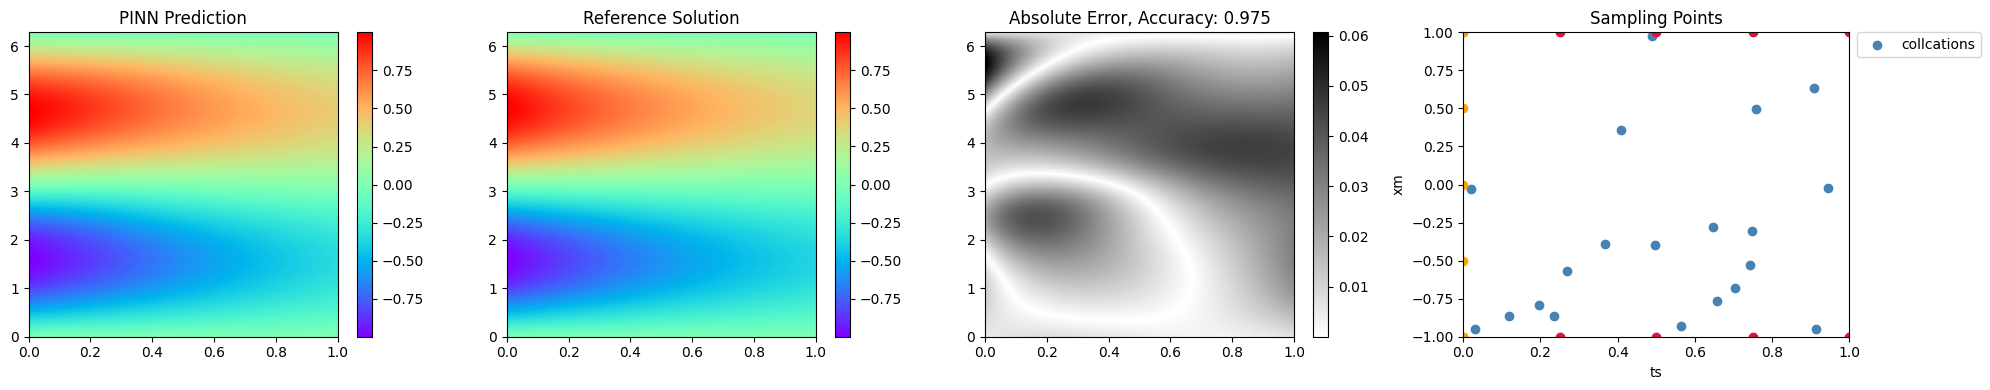

In [11]:
set_seed(42)  # Set seed for reproducibility

# simple pinn architecture
arch = [2] + [32] * 3 + [1]  # Input layer, hidden layers, output layer
act = nn.Tanh  # Activation function
net_u = MLP(arch, act)
device = torch.device('cpu')
# device = torch.device('mps')
model_diffusion = pinn_diffusion(net_u, device=device)


# create the sampler for the problem
sampler = Sampler(spans=[(-1, 1), (0, 1)])

epochs = 10000

# uncommet these and then try the code to see the difference

# sampling_methods = ['grid', 'grid', 'grid']  
# sampling_methods = ['lhs', 'grid', 'grid']  
sampling_methods = ['random', 'grid', 'grid']

num_dom = 20  # Number of domain points
num_ic = 5 # Number of initial condition points
num_bc = 5  # Number of boundary condition points

optimizer = torch.optim.Adam  # Optimizer to use

dom_points, ic_points, bc_left_points, bc_right_points = sampler.sample(num_dom=num_dom, num_ic=num_ic, num_bc=num_bc, method=sampling_methods)

model_diffusion.train_net(dom_points, ic_points, bc_left_points, bc_right_points, epochs=epochs, optimizer=optimizer, log_interval=1000)
model_diffusion.evaluate(num_x=256, num_t=100)

Now we use adaptive sampling. We sample 5 new points each 1000 epochs, and train for 10000 epochs in total.

[Adam]: Iteration 0, Total loss: 3.158e+01, PDE Loss: 3.106e+01, IC Loss: 4.500e-01, BC Left Loss: 3.132e-02, BC Right Loss: 4.620e-02
Mean Relative Error: 0.0004
[Adam]: Iteration 0, Total loss: 7.348e-01, PDE Loss: 7.290e-01, IC Loss: 4.878e-03, BC Left Loss: 2.440e-04, BC Right Loss: 7.435e-04
Mean Relative Error: 0.0002
[Adam]: Iteration 0, Total loss: 1.152e+00, PDE Loss: 1.151e+00, IC Loss: 2.232e-04, BC Left Loss: 2.748e-05, BC Right Loss: 4.522e-05
Mean Relative Error: 0.0002
[Adam]: Iteration 0, Total loss: 1.487e+00, PDE Loss: 1.487e+00, IC Loss: 9.099e-06, BC Left Loss: 6.313e-05, BC Right Loss: 1.059e-05
Mean Relative Error: 0.0010
[Adam]: Iteration 0, Total loss: 1.248e+00, PDE Loss: 1.248e+00, IC Loss: 6.321e-05, BC Left Loss: 1.377e-05, BC Right Loss: 7.297e-06
Mean Relative Error: 0.0002
[Adam]: Iteration 0, Total loss: 3.397e-01, PDE Loss: 3.397e-01, IC Loss: 1.044e-06, BC Left Loss: 2.814e-06, BC Right Loss: 2.139e-05
Mean Relative Error: 0.0001
[Adam]: Iteration 0, T

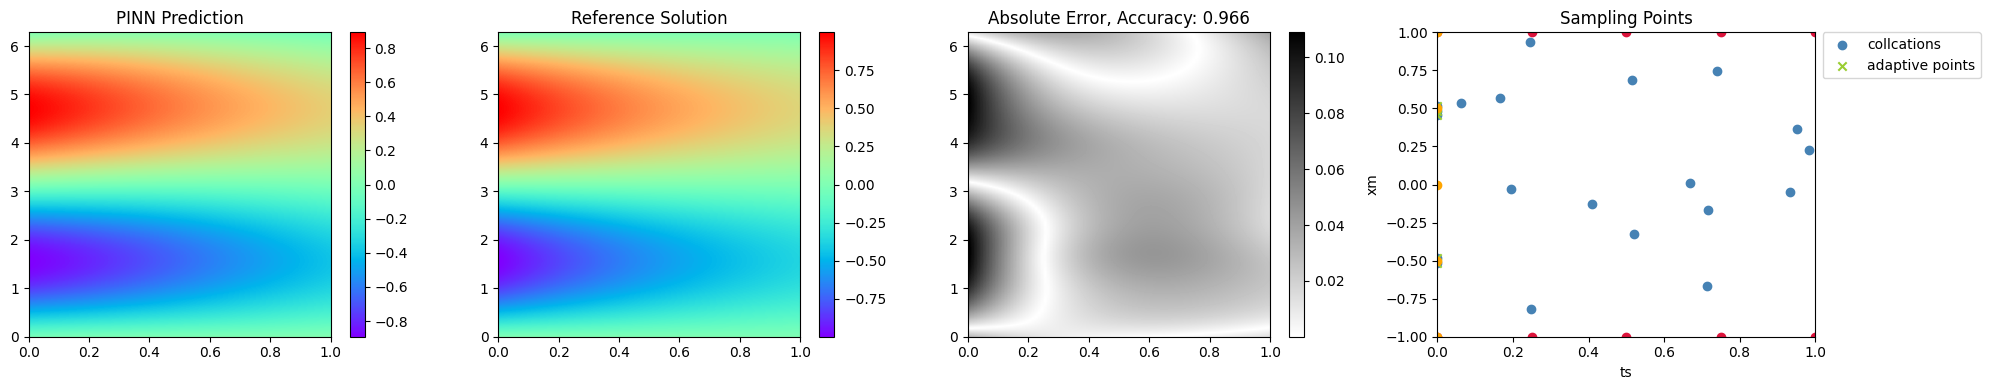

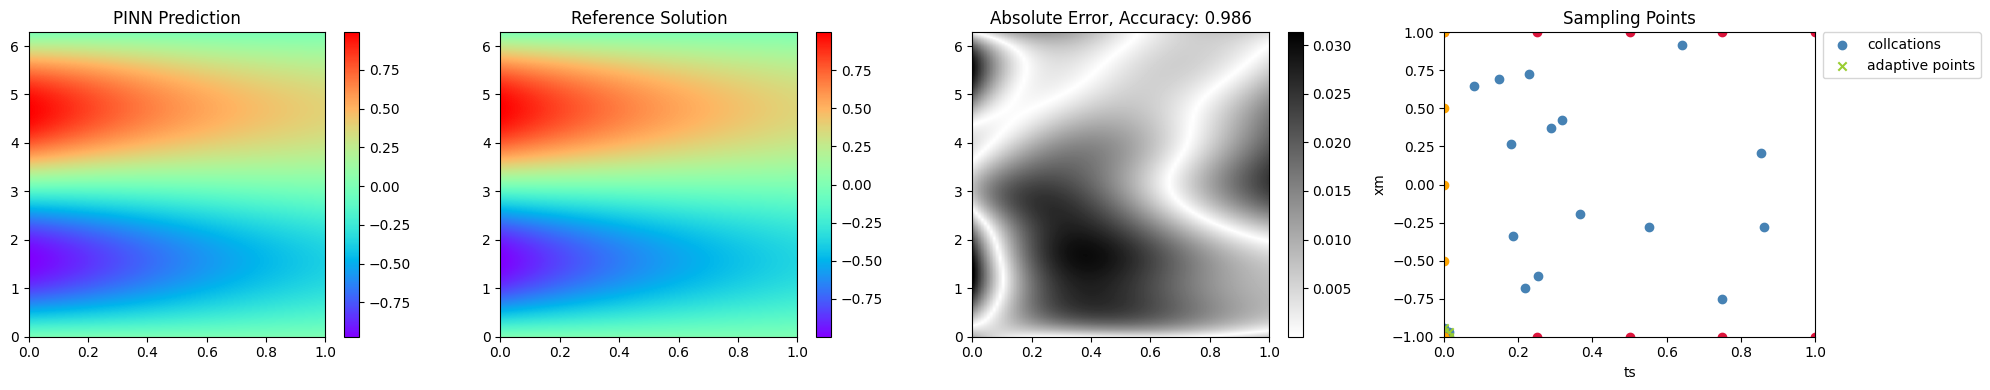

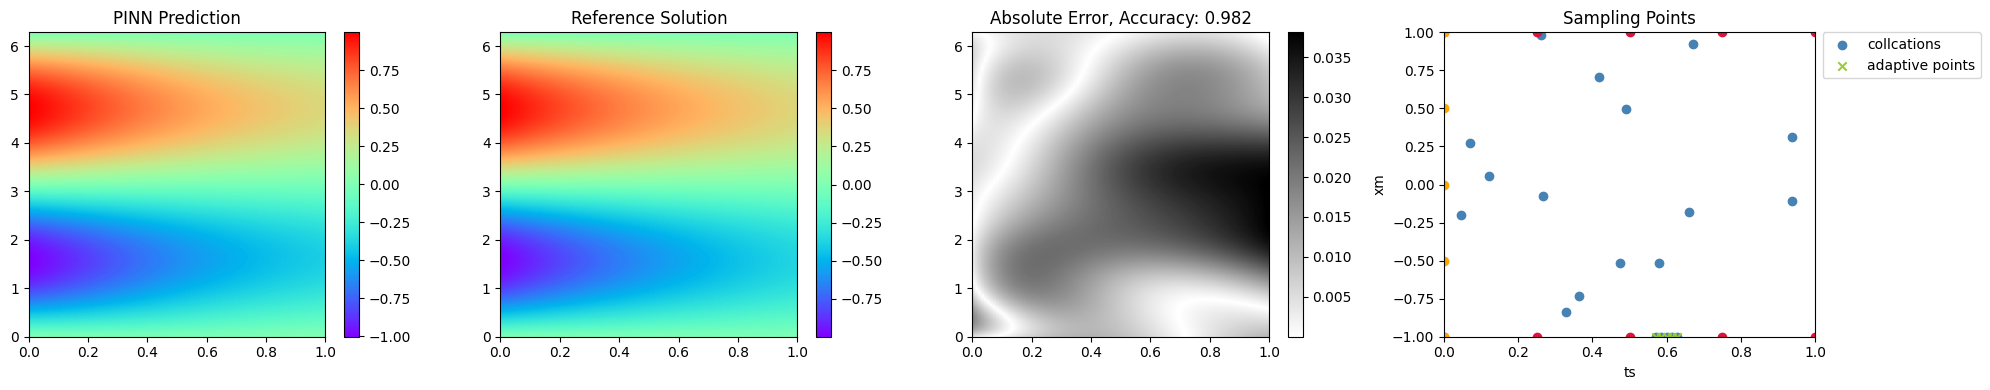

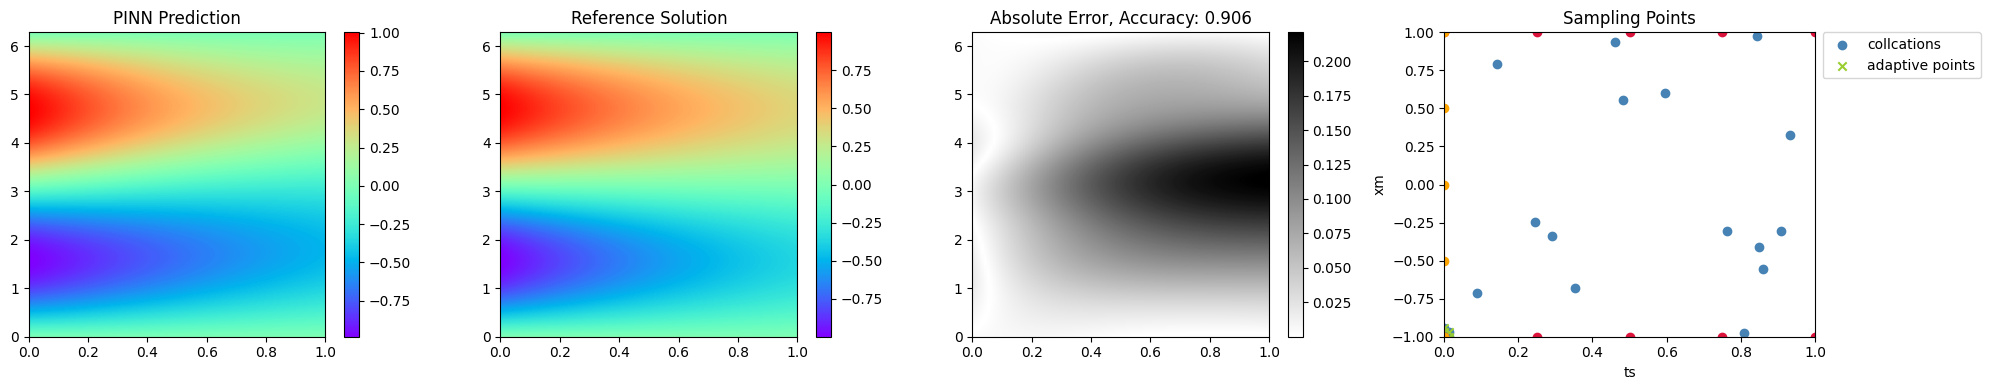

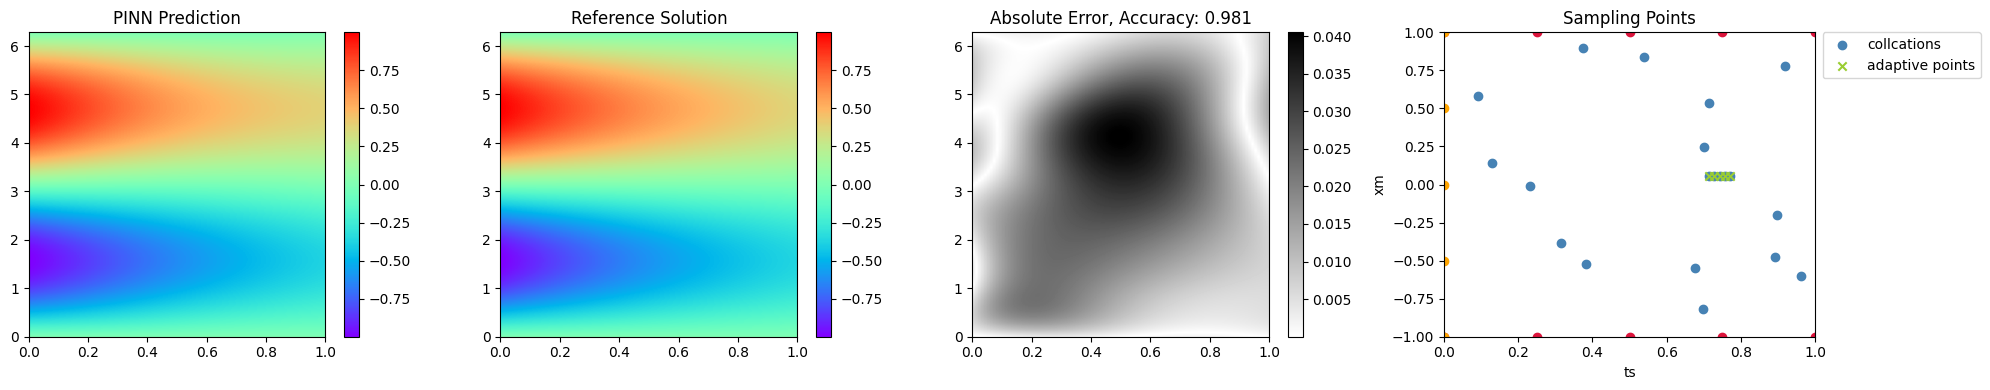

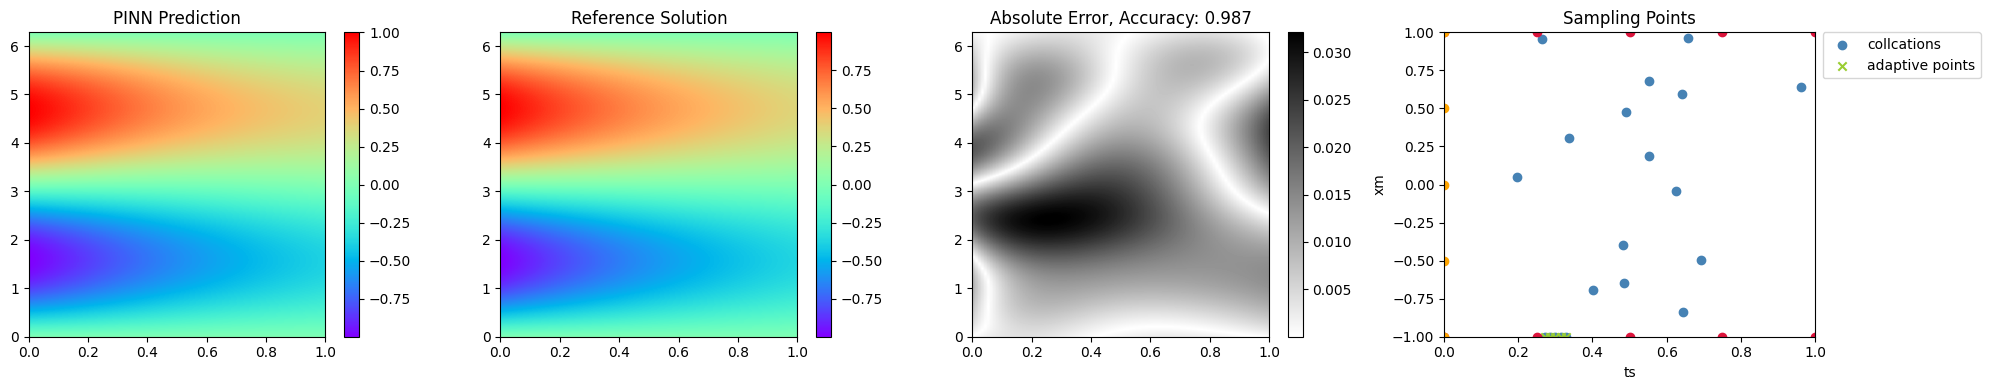

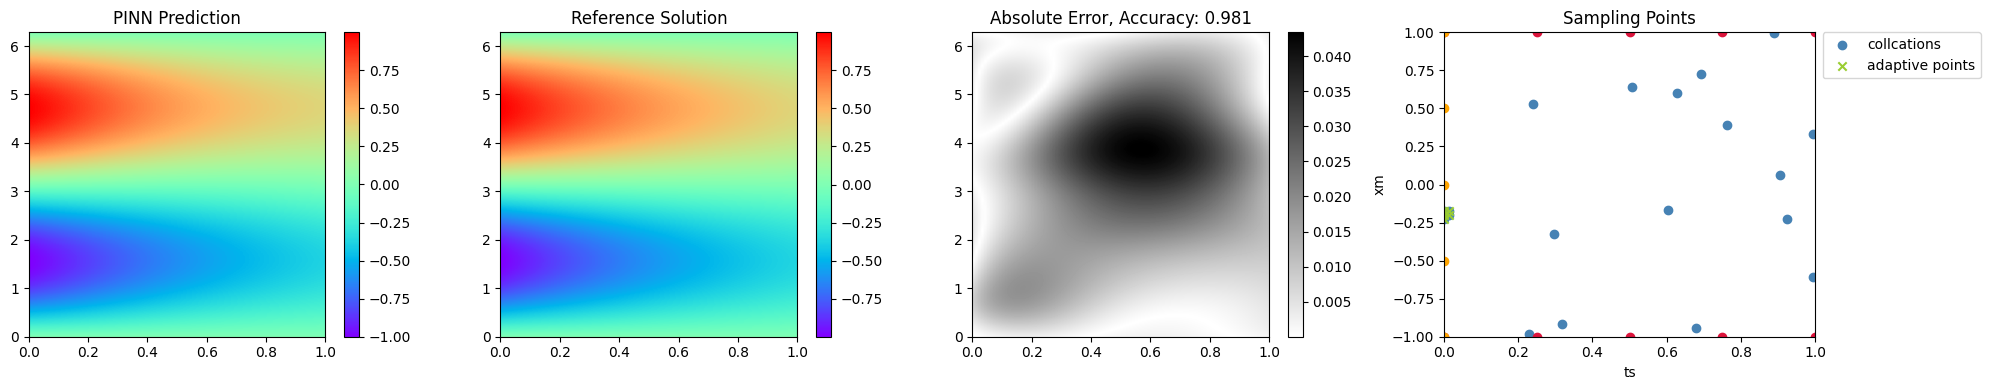

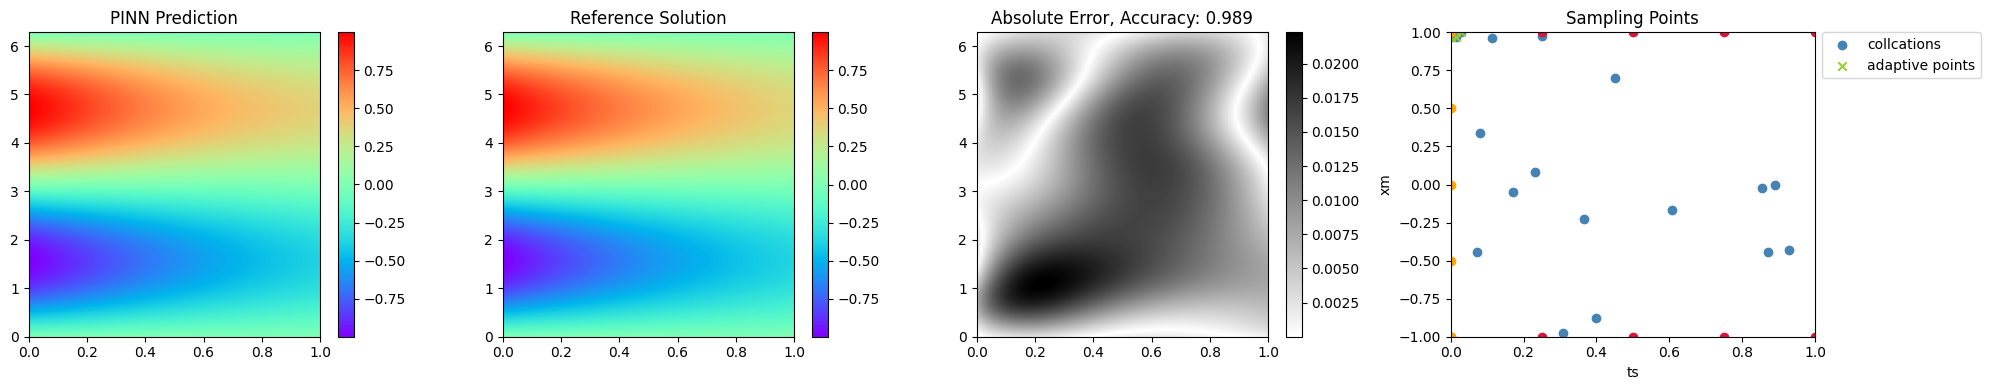

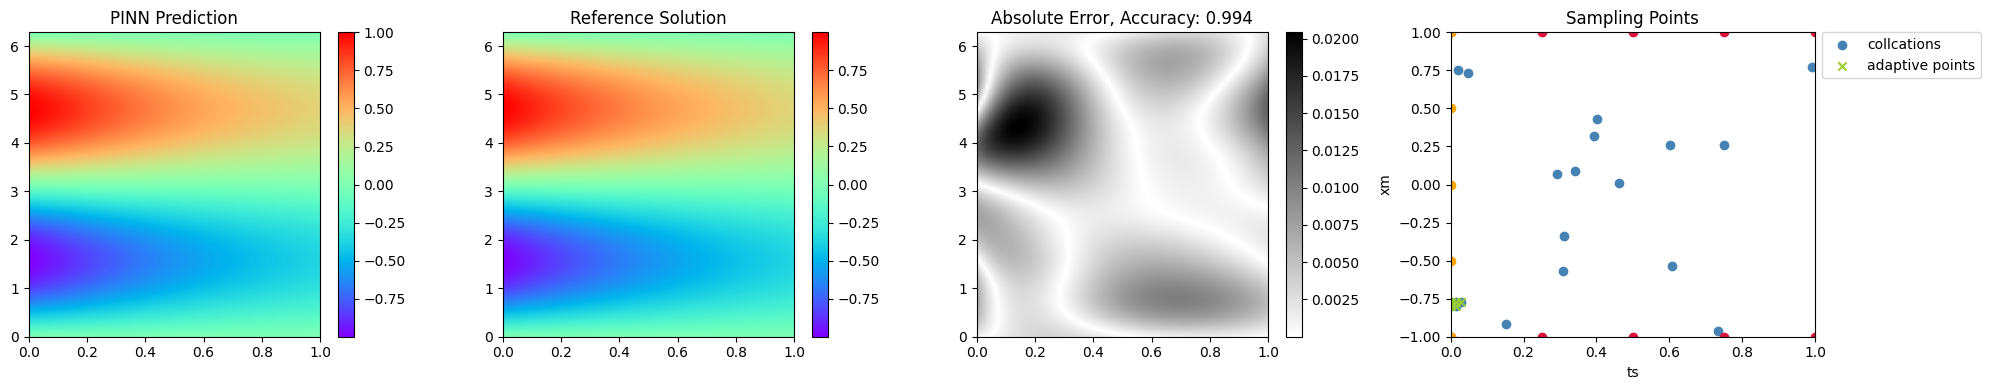

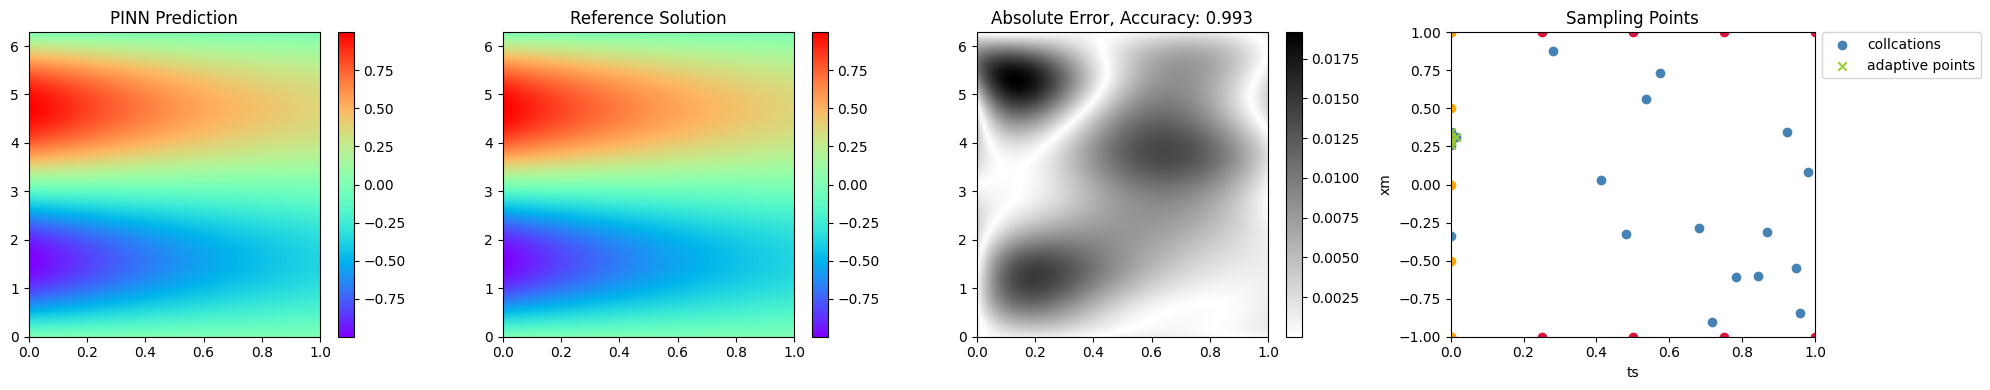

In [12]:
# simple pinn architecture
arch = [2] + [32] * 3 + [1]  # Input layer, hidden layers, output layer
act = nn.Tanh  # Activation function
net_u = MLP(arch, act)
device = torch.device('cpu')
# device = torch.device('mps')
model_diffusion = pinn_diffusion(net_u, device=device)

# create the sampler for the problem
sampler = Sampler(spans=[(-1, 1), (0, 1)])

epochs = 10000

sampling_methods = ['random', 'grid', 'grid']

num_dom = 15  # Number of domain points
num_ic = 5 # Number of initial condition points
num_bc = 5  # Number of boundary condition points

optimizer = torch.optim.Adam  # Optimizer to use
RESAMPLE_FREQUENCY = 1000  # Resample every 1000 epochs

# number of base points to evaluate the residual or gradients and then use them for adaptive sampling
NUM_BASE_POINTS = 5000
NUM_ADAPTIVE_POINTS = 5

base_points = sampler.sample_domain_points(num_points=NUM_BASE_POINTS, method='grid')
# a loop that resamples the points every RESAMPLE_FREQUENCY epochs but in total still train for 10000 epochs
for epoch in range(0, epochs, RESAMPLE_FREQUENCY):
    # Sample new points
    dom_points, ic_points, bc_left_points, bc_right_points = sampler.sample(num_dom=num_dom, num_ic=num_ic, num_bc=num_bc, method=sampling_methods)
    
    # Use adaptive sampling to select the most informative points
    # adaptive_points = model_diffusion.adaptive_sampling(num_points=NUM_ADAPTIVE_POINTS, base_grid_points=base_points, method='gar')
    adaptive_points = model_diffusion.adaptive_sampling(num_points=NUM_ADAPTIVE_POINTS, base_grid_points=base_points, method='rar')

    # Combine the adaptive points with the sampled points
    dom_points = torch.cat((dom_points, adaptive_points), dim=0)

    # Train the model on the sampled points
    model_diffusion.train_net(dom_points, ic_points, bc_left_points, bc_right_points, epochs=RESAMPLE_FREQUENCY, optimizer=optimizer, log_interval=1000)

    model_diffusion.evaluate(num_x=256, num_t=100)

We see a slight increase in the accuracy of the model. Now lets check the last technique adaptive weights and try to implement all in a more difficult problem. 

## Adaptive Weights

We already know the assigning proper weights for the losses are very important to adjust the scales of the losses. Otherwise since the scales of the losses will be different the problem will be very hard to optimize. Methods such as non-dimensionalizing helps with getting the losses into similar scales, but for complicated problems its not always the case, and manually finding the best weights might be very challenging. To overcome this issue some self adaptive loss balancing algorithms have been developed. Mainly there are two types of self balancing algorithms, gradient norm-based and Neural Tangent Kernel (NTK) based.

1. **Gradient Norm (GN) based:** This method balances the losses by ensuring that the gradient magnitudes of different loss components are similar. The idea is that if one loss term has much larger gradients than others, it will dominate the training process. The gradient norm method calculates the L2 norm of gradients for each loss component and adjusts the weights to balance these gradient magnitudes. The weights are updated dynamically during training:

   $$w_i^{(k+1)} = w_i^{(k)} \cdot \frac{\bar{G}}{G_i^{(k)}}$$
   
   where $w_i^{(k)}$ is the weight for loss component $i$ at iteration $k$, $G_i^{(k)}$ is the gradient norm of loss $i$, and $\bar{G}$ is the average gradient norm across all loss components.

2. **NTK based:** The Neural Tangent Kernel approach uses the concept that the training dynamics of neural networks can be approximated by their tangent kernels. This method balances the losses by considering how each loss component affects the network's learning dynamics. It computes the NTK for each loss term and adjusts weights to ensure balanced training across all physics constraints and boundary conditions. The NTK-based weights are computed as:

   $$w_i = \frac{1}{\text{trace}(K_i)}$$
   
   where $K_i$ is the NTK matrix for loss component $i$.

We now consider the 1 dimensional wave equation:

$$\frac{\partial^2 u}{\partial t^2} - 4\frac{\partial^2 u}{\partial x^2} = 0$$
$$u(0, t) = u(1, t) = 0, \quad t\in[0, 1]$$
$$u(x, 0) = \sin(\pi x) + \frac{1}{2}\sin(4\pi x), \quad x\in[0,1]$$
$$\frac{\partial u}{\partial t}(x, 0), \quad x\in[0,1]$$

The exact solution of this is:
$$u(x, t) = \sin(\pi x)\cos(2\pi t) + \frac{1}{2}\sin(4\pi x)\cos(8\pi t)$$

And below we create a PINN model with adaptive sampling and NTK based adaptive loss balancing method implemented. 

In [13]:
u_real_wave = lambda x, t: np.sin(np.pi * x) * np.cos(2 * np.pi * t) + 1/2 * np.sin(4 * np.pi * x) * np.cos(8 * np.pi * t)

class PINN_wave(torch.nn.Module):
    def __init__(
        self,
        model,
        device=torch.device("cpu")
    ):
        super().__init__()
        self.device = device
        self.model = model.to(self.device)

    def net_u(self, x, t):
        inputs = torch.cat((x, t), dim=1)
        u = self.model(inputs)
        return u
    
    def u_t_func(self, x, t):
        u = self.net_u(x, t)
        u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
        return u_t
    
    def pde_residual(self, x, t):
        u = self.net_u(x, t)
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
        u_tt = torch.autograd.grad(u_t, t, torch.ones_like(u_t), create_graph=True)[0]

        pde_residual = u_tt - 4 * u_xx
        return pde_residual

    def ic_func(self, x):
        with torch.no_grad():
            return torch.sin(torch.pi * x) + 1/2 * torch.sin(4 * torch.pi * x)
        
    def adaptive_sampling(self, num_points, base_grid_points, method):
        base_grid_x = base_grid_points[:, 0:1].to(self.device).requires_grad_(True)
        base_grid_t = base_grid_points[:, 1:2].to(self.device).requires_grad_(True)

        self.eval()
        if method == 'gar':
            u = self.net_u(base_grid_x, base_grid_t)

            # calculate gradients to see the steepest prediction points
            u_x = torch.autograd.grad(u, base_grid_x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
            u_t = torch.autograd.grad(u, base_grid_t, torch.ones_like(u), create_graph=True, retain_graph=True)[0]

            _, idx_u_x = torch.topk(u_x.squeeze().abs(), num_points)
            _, idx_u_t = torch.topk(u_t.squeeze().abs(), num_points)

            idx = torch.cat((idx_u_x, idx_u_t), dim=0)
            idx = torch.unique(idx) 

        if method == 'rar':
            pde_residual = self.pde_residual(base_grid_x, base_grid_t)
            _, idx = torch.topk(pde_residual.squeeze().abs(), num_points)
        
        adaptive_points = base_grid_points[idx, :]
        return adaptive_points
    
    def calc_jacobian(self, output):
        output = output.view(-1)
        size = output.shape[0]
        # Compute batched gradients w.r.t. all parameters except last layer
        gradients = torch.autograd.grad(output, list(self.parameters())[:-1], grad_outputs=torch.eye(size).to(self.device), is_grads_batched=True, retain_graph=True)
        
        # Concatenate  gradients into Jacobian matrix
        jacobian = torch.cat([grad.flatten().view(size, -1) for grad in gradients], dim=1)
        return jacobian

    def calc_ntk(self, jacobian, computation_type='trace'):
        """Compute Neural Tangent Kernel metrics from Jacobian matrix."""
        
        # Define computation methods using Einstein summation
        ntk_operations = {
            'full': lambda jac: torch.einsum('Na,Ma->NM', jac, jac),  # Full NTK matrix
            'diag': lambda jac: torch.einsum('Na,Na->N', jac, jac),   # Diagonal elements
            'trace': lambda jac: torch.einsum('Na,Na->', jac, jac)    # Trace (scalar)
        }
        
        if computation_type not in ntk_operations:
            raise ValueError(f'Metric "{computation_type}" not supported. '
                            f'Choose from: {list(ntk_operations.keys())}')

        return ntk_operations[computation_type](jacobian)
    
    def calculate_adaptive_weights(self, loss_residuals, sampling_strategy, batch_size, return_info=False):
        """Compute NTK-based adaptive weights for loss terms."""
        traces, jacs = [], []

        for res in loss_residuals:
            n = len(res)
            if sampling_strategy == "random": # random-batch technique
                idx = np.random.randint(0, n, batch_size) if batch_size < n else slice(None)
                jac = self.calc_jacobian(res[idx])
                norm = batch_size if batch_size < n else n
            elif sampling_strategy == "topres":  # compute the weight using the points with top residuals
                idx = slice(0, batch_size) if batch_size < n else slice(None)
                jac = self.calc_jacobian(res[idx])
                norm = batch_size if batch_size < n else n
            elif sampling_strategy == "mini": # compute the weight using mini-batch technique
                trace = 0
                for i in range(0, n, batch_size):
                    jac = self.calc_jacobian(res[i:i + batch_size])
                    trace += self.calc_ntk(jac, computation_type='trace').item()
                traces.append(trace / n)
                if return_info:
                    jacs.append(jac)
                continue
            elif sampling_strategy == "full":
                jac = self.calc_jacobian(res)
                norm = n
            else:
                raise ValueError(f"Unknown sampling strategy: {sampling_strategy}. Must be one of 'random', 'topres', 'mini', or 'full'.")

            trace = self.calc_ntk(jac, computation_type='trace').item()
            traces.append(trace / norm)
            if return_info:
                jacs.append(jac)

        traces = np.array(traces)
        weights = traces.sum() / traces
        return (weights, jacs) if return_info else weights
    
    def predict(self, x, t):
        self.model.eval()
        with torch.no_grad():
            x = x.to(self.device)
            t = t.to(self.device)
            return self.net_u(x, t).cpu().numpy()
    
    def evaluate(self, dom_points, ic_points, bc_points, adap_points, num_x=100, num_t=100):

        self.model.eval()

        # Prepare testing grid
        x_test = torch.linspace(0, 1, num_x).reshape(-1, 1).to(self.device)
        t_test = torch.linspace(0, 1, num_t).reshape(-1, 1).to(self.device)
        x_grid, t_grid = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')
        x_grid_flat = x_grid.reshape(-1, 1)
        t_grid_flat = t_grid.reshape(-1, 1)

        # Predict using the trained model
        u_pred = self.predict(x_grid_flat, t_grid_flat).reshape(num_x, num_t)
        # Analytical solution
        # u_analytical = u_wave(x_grid_flat.cpu().numpy(), t_grid_flat.cpu().numpy()).reshape(num_x, num_t)
        u_real = u_real_wave(x_grid_flat.cpu().numpy(), t_grid_flat.cpu().numpy()).reshape(num_x, num_t)

        # Calculate errors
        diff = np.abs(u_pred - u_real)
        #Calculate L2 normalized relative error
        L2_relative_error = np.linalg.norm(diff) / np.linalg.norm(u_real)
        print(f'L2 Normalized Relative Error: {L2_relative_error:.4f}')

        # Calculate accuracy as 1 - normalized RMSE
        acc = 1 - np.sqrt(np.mean(diff ** 2))

        fig, axes = plt.subplots(1, 4, figsize=(20, 4))
        axes = axes.flatten()

        axes[0].imshow(u_pred, aspect='auto', origin='lower', extent=[0.0, 1.0, 0.0, 1], cmap="rainbow")
        axes[0].set_title(f"PINN Prediction")

        axes[1].imshow(u_real, aspect='auto', origin='lower', extent=[0, 1, 0, 1], cmap="rainbow")
        axes[1].set_title("Reference Solution")

        axes[2].imshow(diff, aspect='auto', origin='lower', extent=[0.0, 1.0, 0.0, 1], cmap="binary")
        axes[2].set_title(f"Absolute Error, Accuracy: {acc:.3f}")

        axes[3].scatter(dom_points[:, 1].cpu().numpy(), dom_points[:, 0].cpu().numpy(), c="steelblue", label="collcations", s=2)
        if adap_points is not None:
            axes[3].scatter(adap_points[:, 1].cpu().numpy(), adap_points[:, 0].cpu().numpy(), c="yellowgreen", label="adaptive points", marker="x", s=2)
        axes[3].scatter(bc_points[:, 1].cpu().numpy(), bc_points[:, 0].cpu().numpy(), c="crimson", s=2, label="bc")
        axes[3].scatter(ic_points[:, 1].cpu().numpy(), ic_points[:, 0].cpu().numpy(), c="orange", s=2, label="ic")
        axes[3].set_title("Sampled Points")
        
        plt.colorbar(axes[0].images[0], ax=axes[0])
        plt.colorbar(axes[1].images[0], ax=axes[1])
        plt.colorbar(axes[2].images[0], ax=axes[2])
        plt.tight_layout()

The cell below is the training loop. Play with the hyperparameters, change them and see how they affect the training.

epoch: 0, ic_loss: 7.2734e-01, bc_loss: 6.4594e-03, pde_loss: 4.9399e-05, ic_neu_loss: 4.7023e-06
epoch: 0, ic_weig: 2.4549e+00, bc_weig: 2.3711e+00, pde_weigt: 8.6647e+00, ic_neu_weig: 1.8021e+01, total_loss: 1.8014e+00
L2 Normalized Relative Error: 1.0117
epoch: 1000, ic_loss: 1.9219e-01, bc_loss: 3.6706e-02, pde_loss: 4.5894e-03, ic_neu_loss: 2.1547e-04
epoch: 1000, ic_weig: 1.4281e+01, bc_weig: 1.1662e+01, pde_weigt: 1.4770e+00, ic_neu_weig: 5.9812e+00, total_loss: 3.1809e+00
L2 Normalized Relative Error: 0.9550
epoch: 2000, ic_loss: 1.0659e-01, bc_loss: 2.1000e-02, pde_loss: 1.5534e-02, ic_neu_loss: 7.7174e-03
epoch: 2000, ic_weig: 3.9906e+01, bc_weig: 2.9487e+01, pde_weigt: 1.2279e+00, ic_neu_weig: 7.8963e+00, total_loss: 4.9526e+00
L2 Normalized Relative Error: 0.6118
epoch: 3000, ic_loss: 9.5021e-02, bc_loss: 1.6357e-02, pde_loss: 6.3448e-02, ic_neu_loss: 2.0360e-03
epoch: 3000, ic_weig: 1.1462e+02, bc_weig: 6.9236e+01, pde_weigt: 1.0980e+00, ic_neu_weig: 1.5127e+01, total_loss

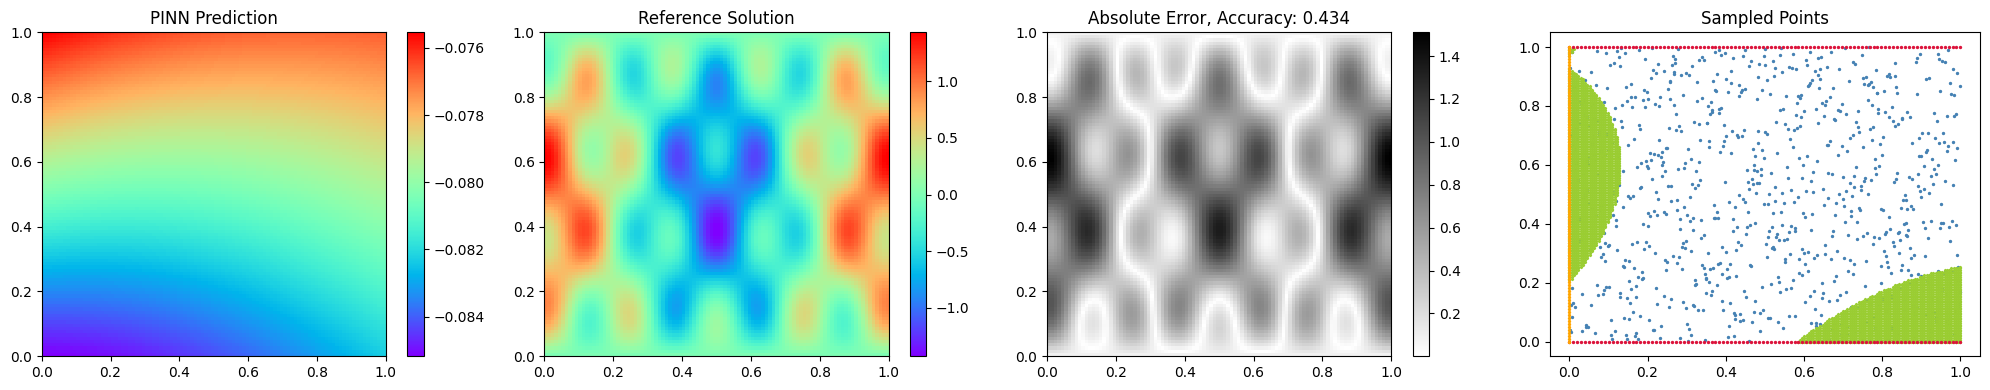

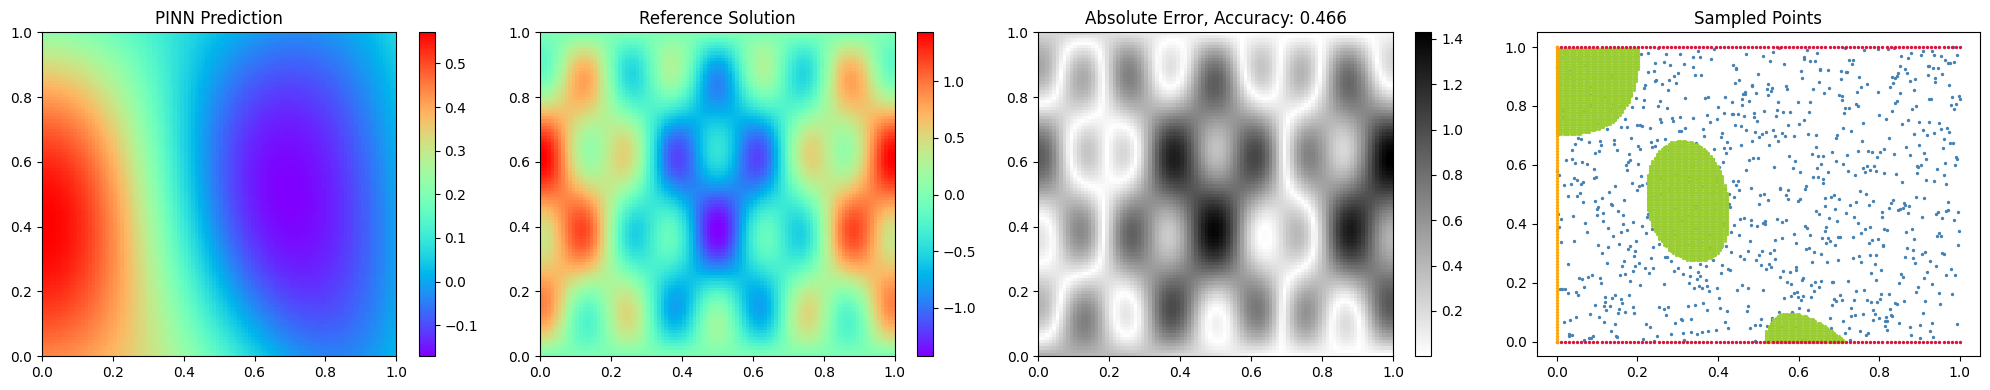

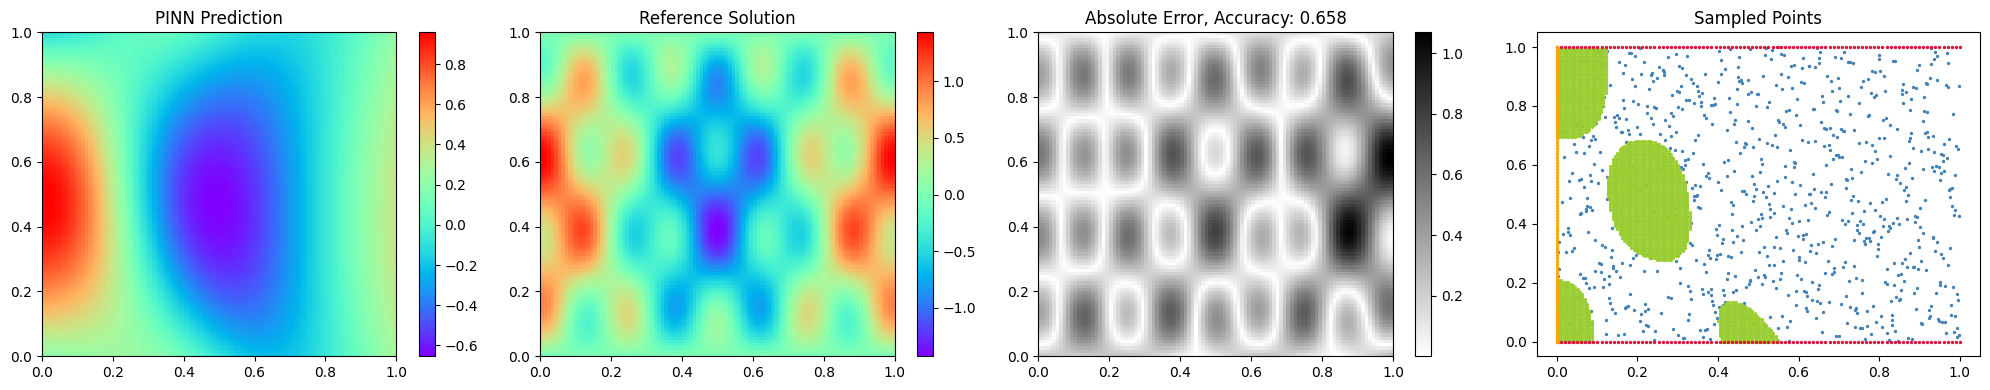

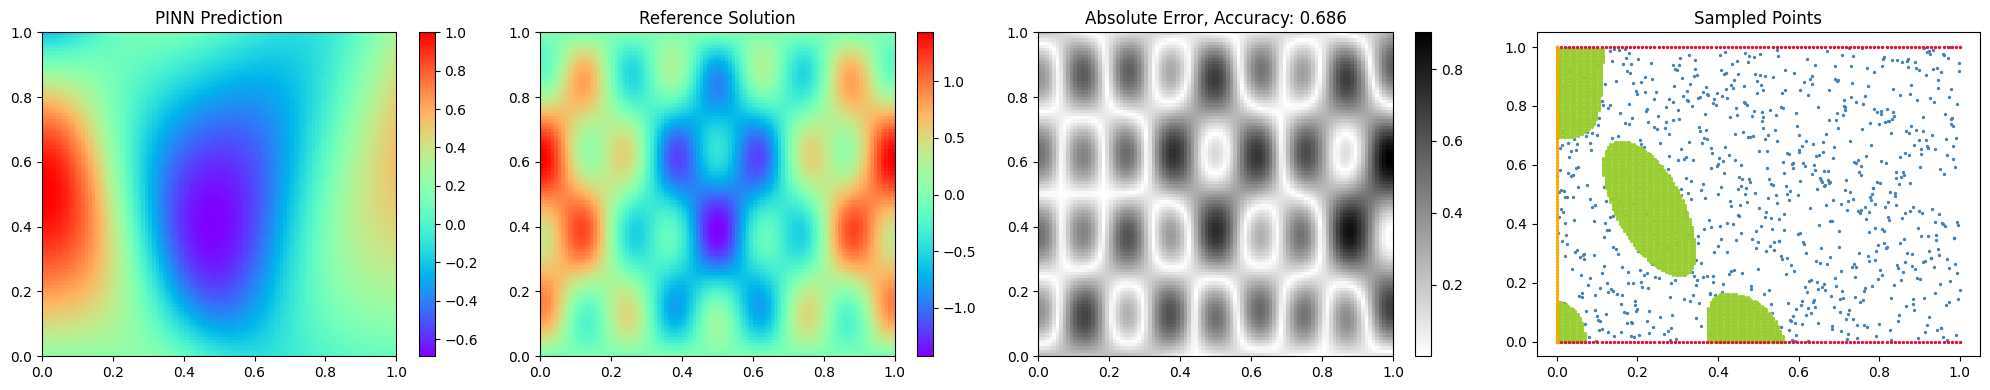

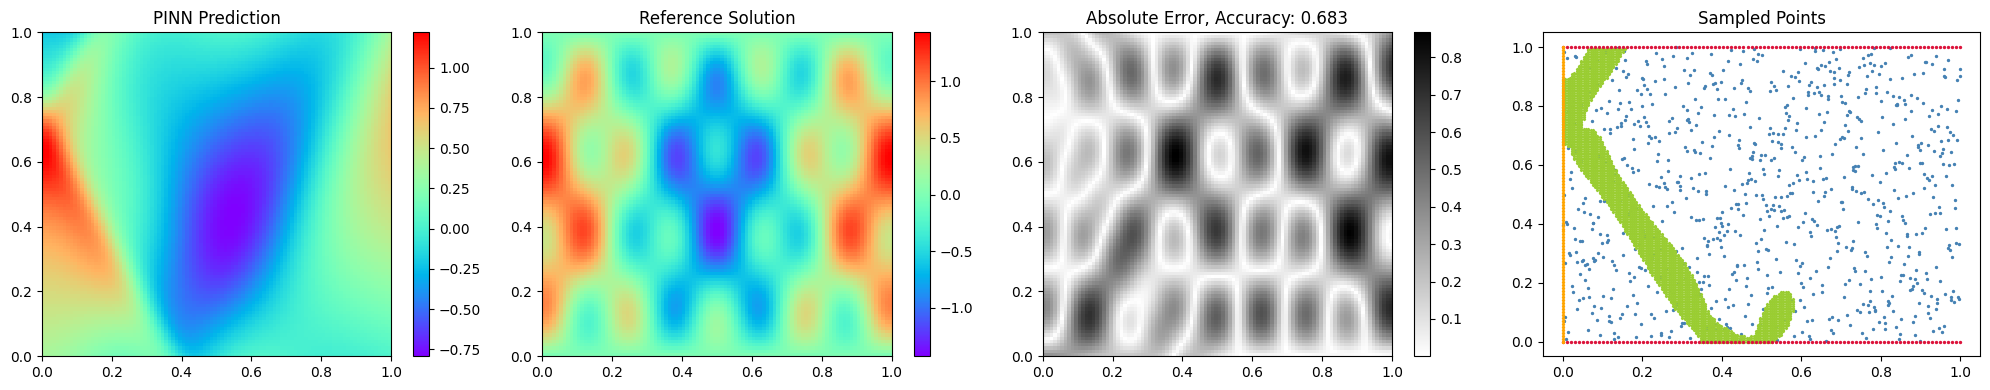

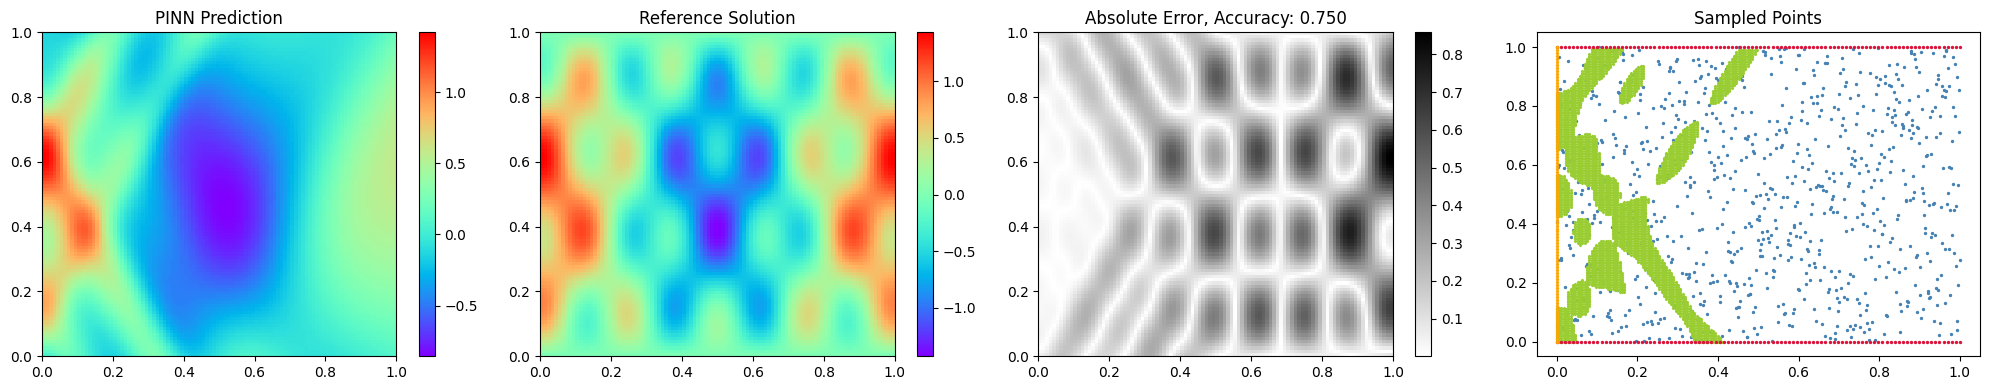

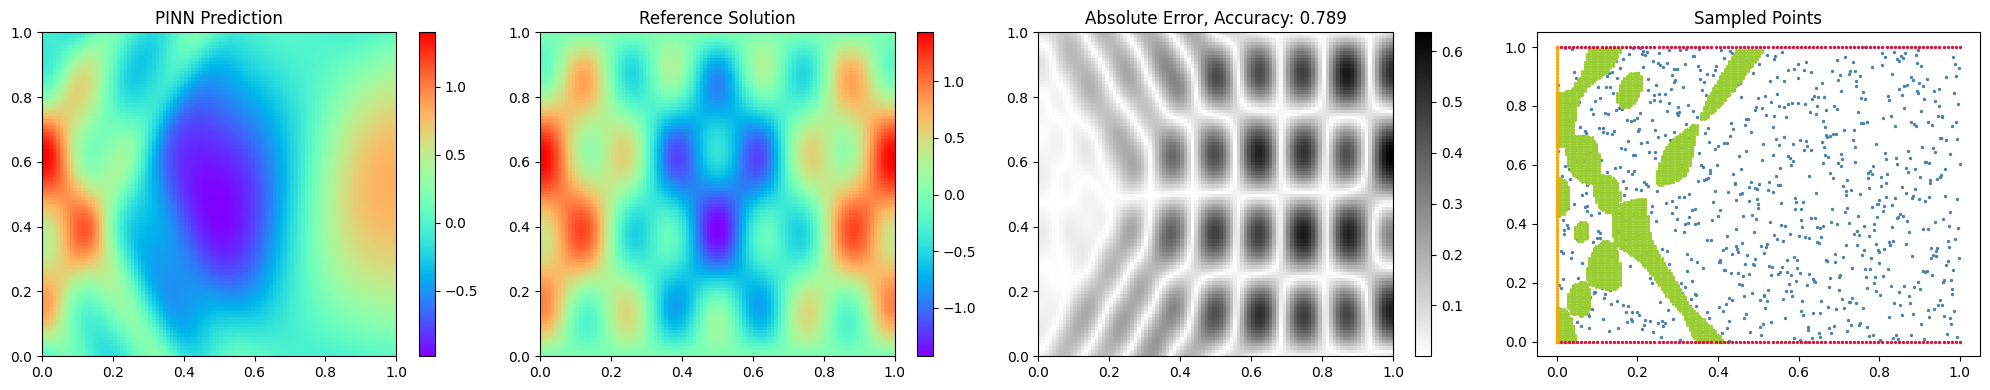

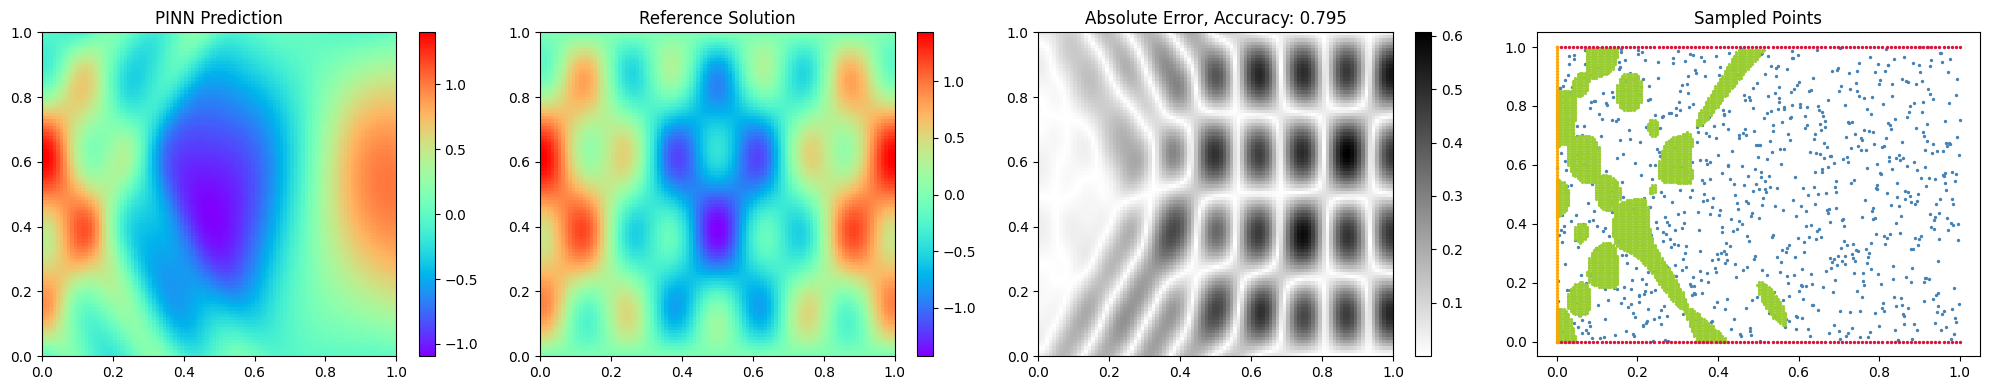

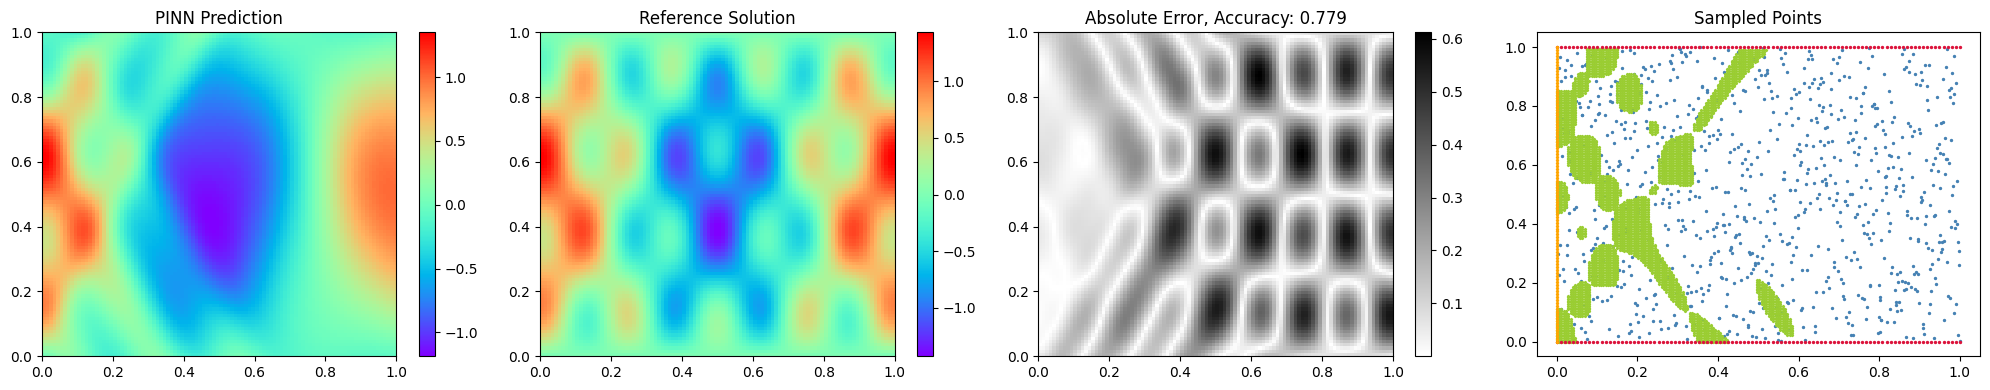

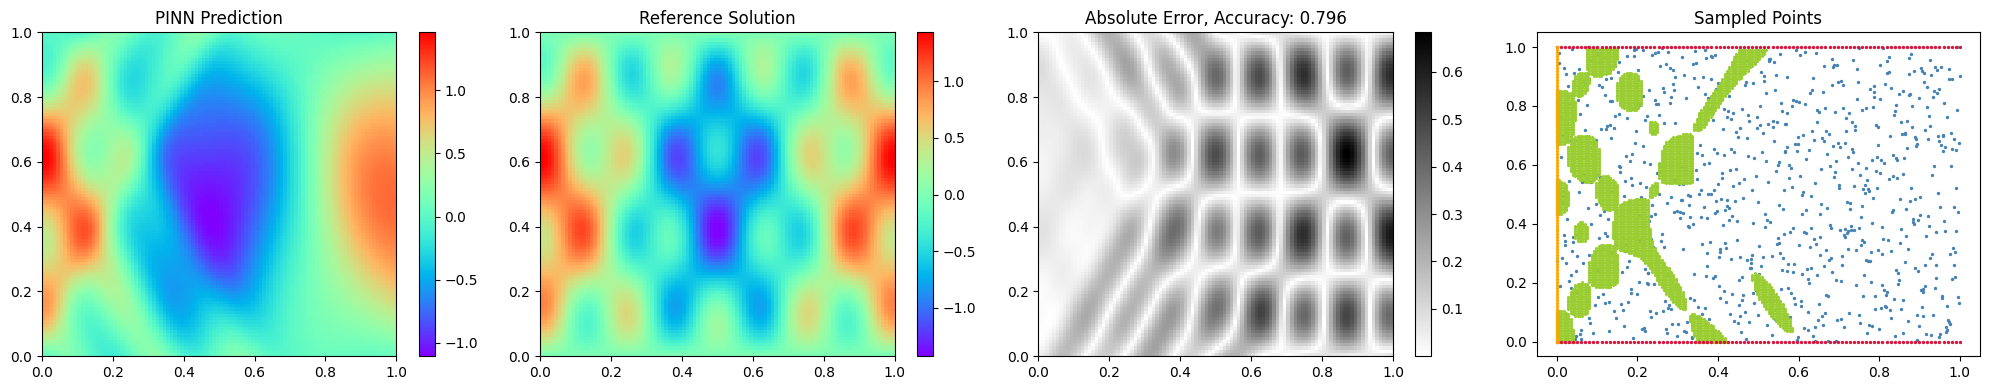

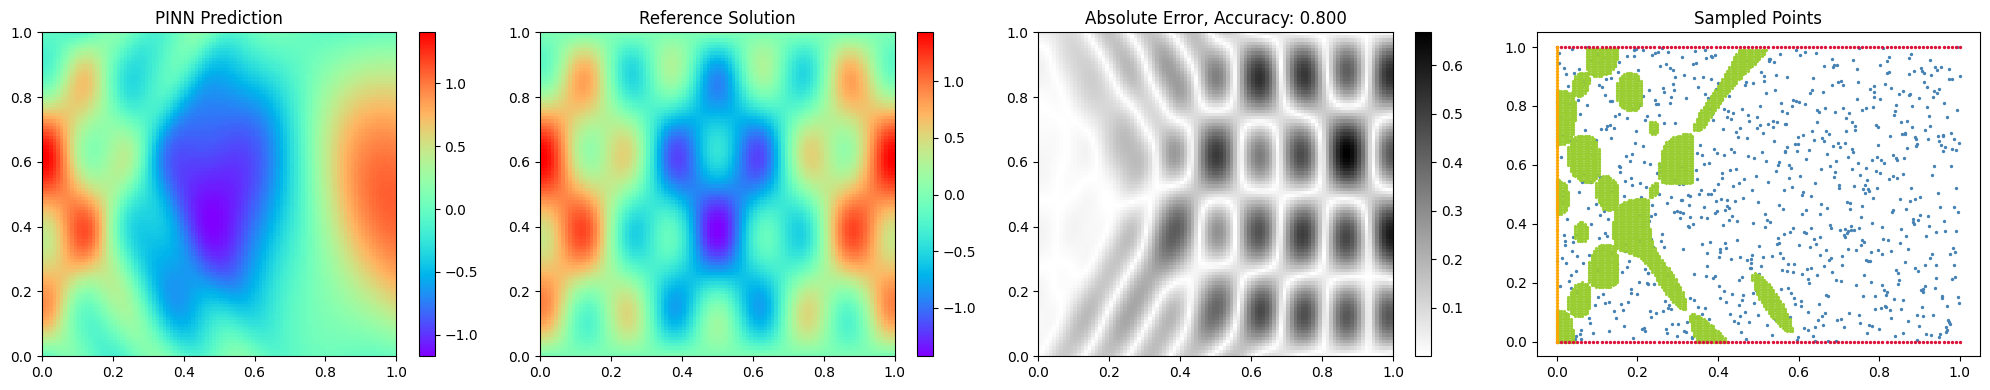

In [16]:
set_seed(42)  # Set seed for reproducibility

# simple pinn architecture
arch = [2] + [60] * 6 + [1]  # Input layer, hidden layers, output layer
act = nn.Tanh  # Activation function
net_u = MLP(arch, act)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

model_wave = PINN_wave(net_u, device=device)

# create the sampler for the problem
sampler = Sampler(spans=[(0, 1), (0, 1)])

optimizer = torch.optim.Adam(model_wave.parameters(), lr=1e-3)  # Optimizer to use
loss_fn = torch.nn.MSELoss()  # Loss function

# number of base points to evaluate the residual or gradients and then use them for adaptive sampling
NUM_DOM = 900  # Number of domain points
NUM_IC = 100  # Number of initial condition points
NUM_BC = 100  # Number of boundary condition points

SAMPLING_METHODS = ['lhs', 'grid', 'grid']  # [residual points, initial condition points, boundary condition points] lhs, grid or random

EPOCHS = 10000

NTK_BATCH_SIZE = 300  # Batch size for NTK calculations
WEIGHT_UPDATE_INTERVAL = 1000  # Update weights every 1000 iterations

ADAPTIVE_SAMPLING_METHOD = 'gar'  # gar or rar
RESAMPLE_FREQUENCY = 1000  # Resample every 1000 epochs
NUM_ADAPTIVE_BASE_POINTS = 30000 # Number of base points for adaptive sampling
NUM_ADAPTIVE_POINTS = 2000 # Number of adaptive points to sample from those base points

ic_func = lambda x: torch.sin(torch.pi * x) + 1/2 * torch.sin(4 * torch.pi * x)

for epoch in range(EPOCHS):
    model_wave.train()
    optimizer.zero_grad()
    if epoch % RESAMPLE_FREQUENCY == 0:
        # Sample new points
        dom_points, ic_points, bc_left_points, bc_right_points = sampler.sample(num_dom=NUM_DOM, num_ic=NUM_IC, num_bc=NUM_BC, method=SAMPLING_METHODS, device=model_wave.device)
        dom_points = dom_points.to(model_wave.device)

        adaptive_base_points = sampler.sample_domain_points(num_points=NUM_ADAPTIVE_BASE_POINTS, method='grid', device=model_wave.device)
        adaptive_points = model_wave.adaptive_sampling(num_points=NUM_ADAPTIVE_POINTS, base_grid_points=adaptive_base_points, method=ADAPTIVE_SAMPLING_METHOD)

        # Combine the adaptive points with the sampled points
        combined_domain = torch.cat((dom_points, adaptive_points), dim=0)
        bc_points = torch.cat((bc_left_points, bc_right_points), dim=0)

        x_dom = combined_domain[:, 0:1].to(model_wave.device).requires_grad_(True)
        t_dom = combined_domain[:, 1:2].to(model_wave.device).requires_grad_(True)
        x_ic = ic_points[:, 0:1].to(model_wave.device).requires_grad_(True)
        t_ic = ic_points[:, 1:2].to(model_wave.device).requires_grad_(True)
        x_bc = bc_points[:, 0:1].to(model_wave.device).requires_grad_(True)
        t_bc = bc_points[:, 1:2].to(model_wave.device).requires_grad_(True)

    pde_residual = model_wave.pde_residual(x_dom, t_dom)
    pde_loss = loss_fn(pde_residual, torch.zeros_like(pde_residual))
    bc_forward = model_wave.net_u(x_bc, t_bc)
    bc_loss = loss_fn(bc_forward, torch.zeros_like(bc_forward))
    ic_neumann_res = model_wave.u_t_func(x_ic, t_ic)
    ic_neumann_loss = loss_fn(ic_neumann_res, torch.zeros_like(ic_neumann_res))
    ic_forward = model_wave.net_u(x_ic, t_ic)
    ic_real = ic_func(x_ic).detach()
    ic_loss = loss_fn(ic_forward, ic_real)

    if epoch % WEIGHT_UPDATE_INTERVAL == 0:
        # Calculate NTK-based adaptive weights
        ntk_weights = model_wave.calculate_adaptive_weights(
            [pde_residual, ic_forward, bc_forward, ic_neumann_res],
            sampling_strategy='random',
            batch_size=NTK_BATCH_SIZE,
            return_info=False
        )
        pde_weight, ic_weight, bc_weight, ic_neumann_weight = ntk_weights

        print(f"epoch: {epoch}, "
            f"ic_loss: {ic_loss.item():.4e}, "
            f"bc_loss: {bc_loss.item():.4e}, "
            f"pde_loss: {pde_loss.item():.4e}, "
            f"ic_neu_loss: {ic_neumann_loss.item():.4e}")
        
    total_loss = ic_weight * ic_loss \
        + bc_weight * bc_loss \
        + pde_weight * pde_loss \
        + ic_neumann_weight * ic_neumann_loss
    
    if epoch % WEIGHT_UPDATE_INTERVAL == 0:
        print(f"epoch: {epoch}, "
            f"ic_weig: {ic_weight:.4e}, "
            f"bc_weig: {bc_weight:.4e}, "
            f"pde_weigt: {pde_weight:.4e}, "
            f"ic_neu_weig: {ic_neumann_weight:.4e}, "
            f"total_loss: {total_loss.item():.4e}")
        
        model_wave.evaluate(dom_points, ic_points, bc_points, adaptive_points)

    total_loss.backward()
    optimizer.step()
model_wave.evaluate(dom_points, ic_points, bc_points, adaptive_points)

Result doesnt look too promising still, probably training further with Adam optimizer would increase the accuracy. However it converges very slow and. We can use another optimizer called `LBFGS`. THe usage of it is slightly different than other otimizer. It requires to wrap the loss calculation in a closure function, because internally the optimzer calls this function several time to keep track of the gradients. Thats also why it is a very memory intensive optimizer but also it is proven that it works well with PINN optimizations, especially first training with `ADAM` then with `LBFGS` is proven to produce better results most of the time.  Below we continue to train the model using `LBFGS`, for a maximum of 10000 iterations but the optimzer most likely stops before that. `One last note about training with LBFGS is that, because it uses the gradients of the rpevious steps in optimization we cannot use adaptive sampling strategies inside the internal steps. But instead we can create outer loops to create to resample. We dont need adaptive sampling here`

Iteration 0: pde_loss = 2.7910e+00, ic_loss = 4.3018e-04, bc_loss = 6.9757e-03, ic_neumann_loss = 1.5748e-03,  Loss = 2.2302e+01
Iteration 0, ic_weig: 3.4093e+03, bc_weig: 2.3388e+03, pde_weigt: 1.0263e+00, ic_neu_weig: 4.0102e+01
L2 Normalized Relative Error: 0.3575
Iteration 1000: pde_loss = 2.7293e+00, ic_loss = 1.1878e-04, bc_loss = 2.7963e-03, ic_neumann_loss = 1.0867e-03,  Loss = 9.7898e+00
Iteration 1000, ic_weig: 1.6680e+03, bc_weig: 1.0159e+03, pde_weigt: 1.0237e+00, ic_neu_weig: 4.6451e+01
L2 Normalized Relative Error: 0.2348
Iteration 2000: pde_loss = 7.0468e-01, ic_loss = 4.0706e-05, bc_loss = 1.8982e-03, ic_neumann_loss = 3.5639e-04,  Loss = 2.7342e+00
Iteration 2000, ic_weig: 1.2102e+03, bc_weig: 7.7053e+02, pde_weigt: 1.0324e+00, ic_neu_weig: 3.4151e+01
L2 Normalized Relative Error: 0.1493
Iteration 3000: pde_loss = 1.7572e-01, ic_loss = 1.3929e-05, bc_loss = 2.9209e-04, ic_neumann_loss = 3.1708e-04,  Loss = 4.3416e-01
Iteration 3000, ic_weig: 1.1036e+03, bc_weig: 6.5261

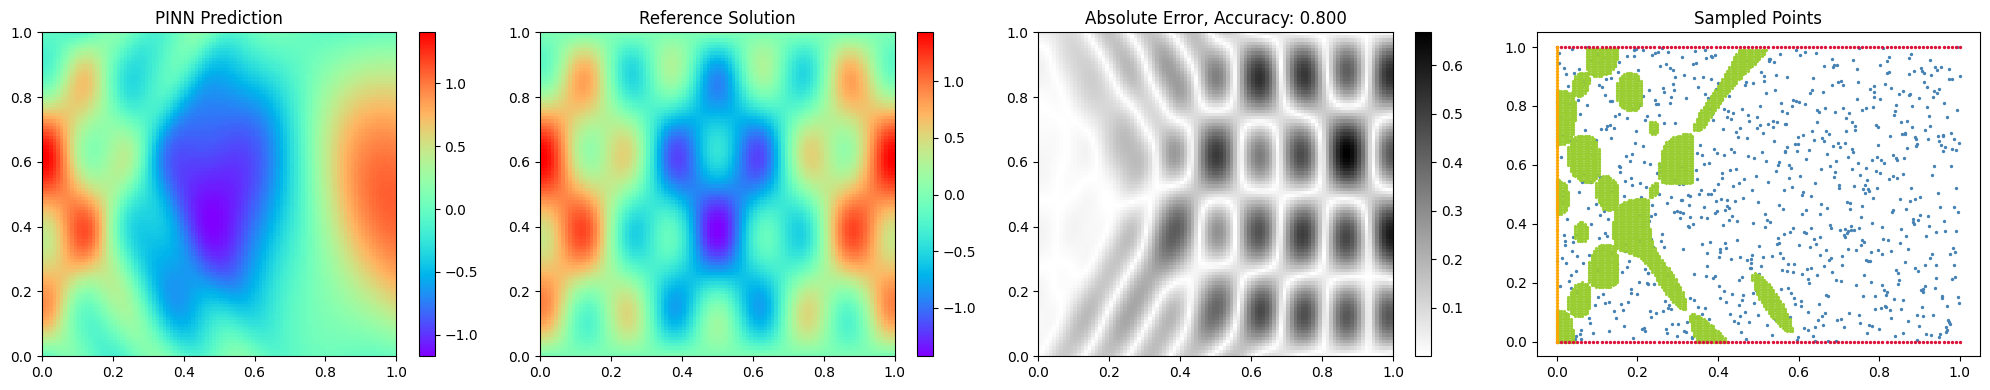

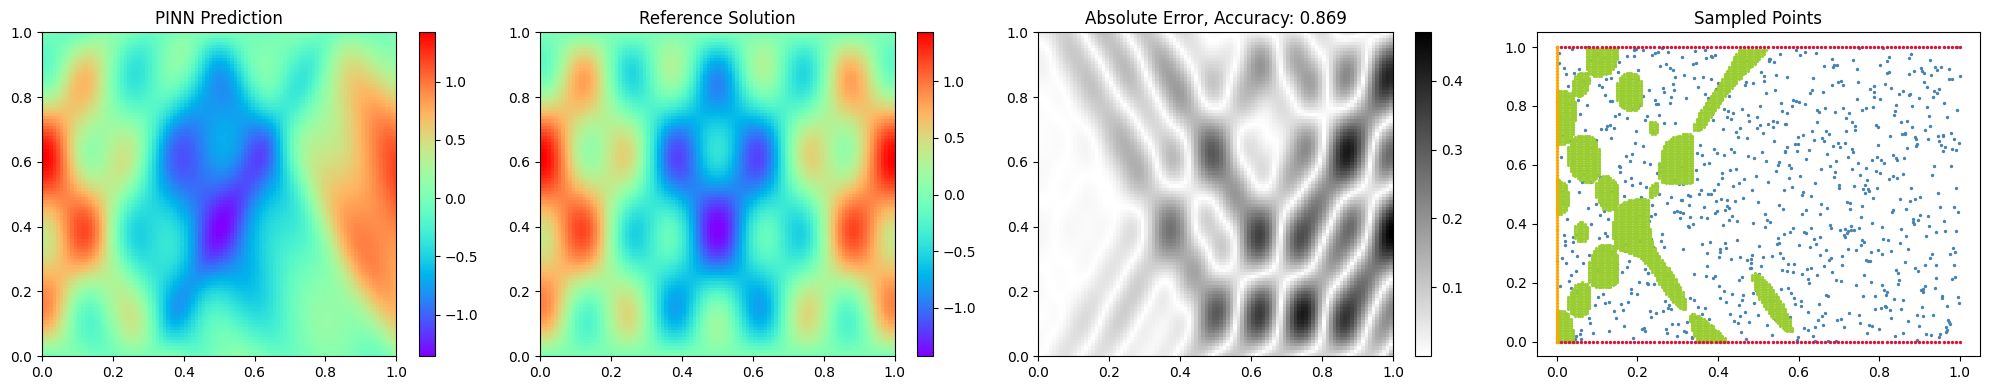

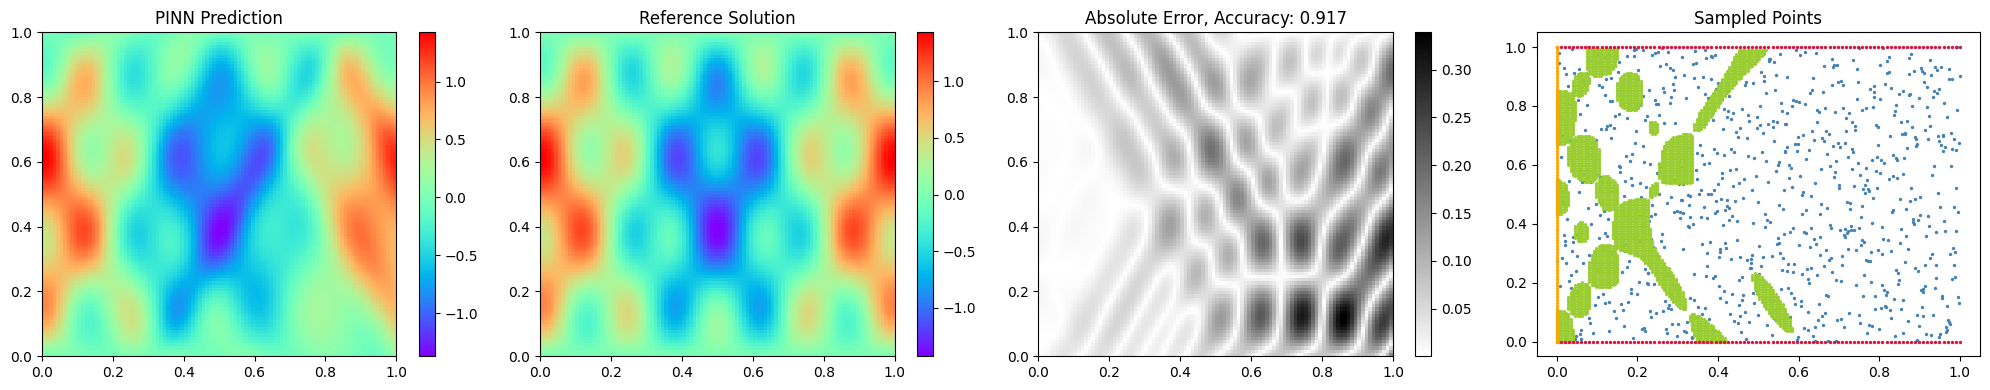

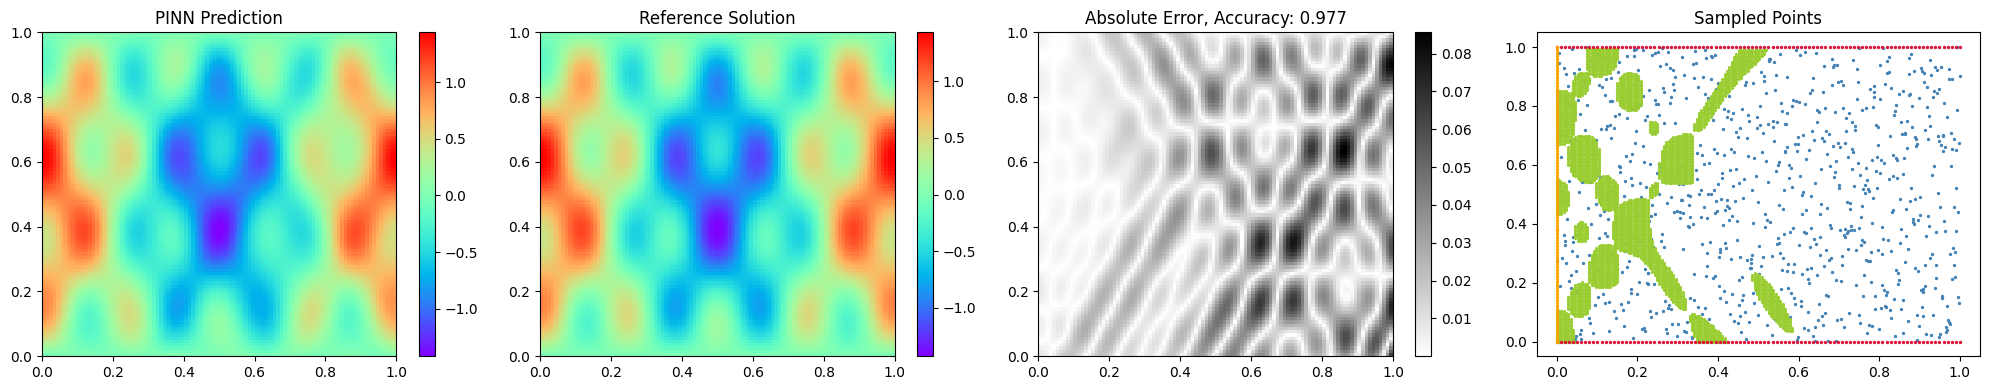

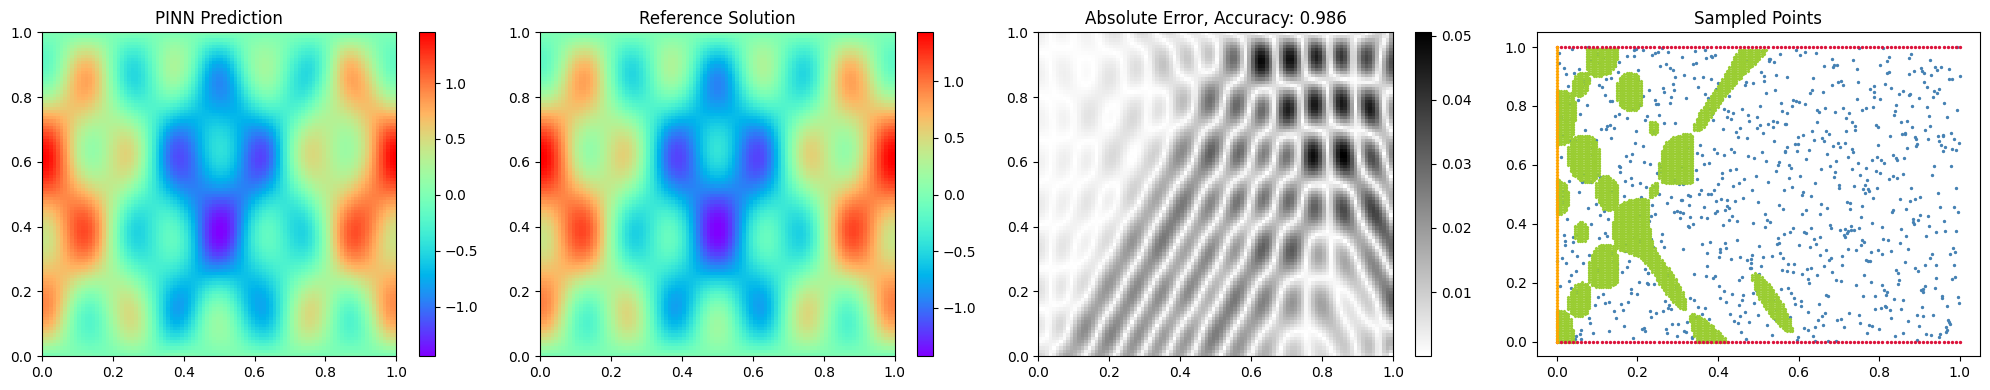

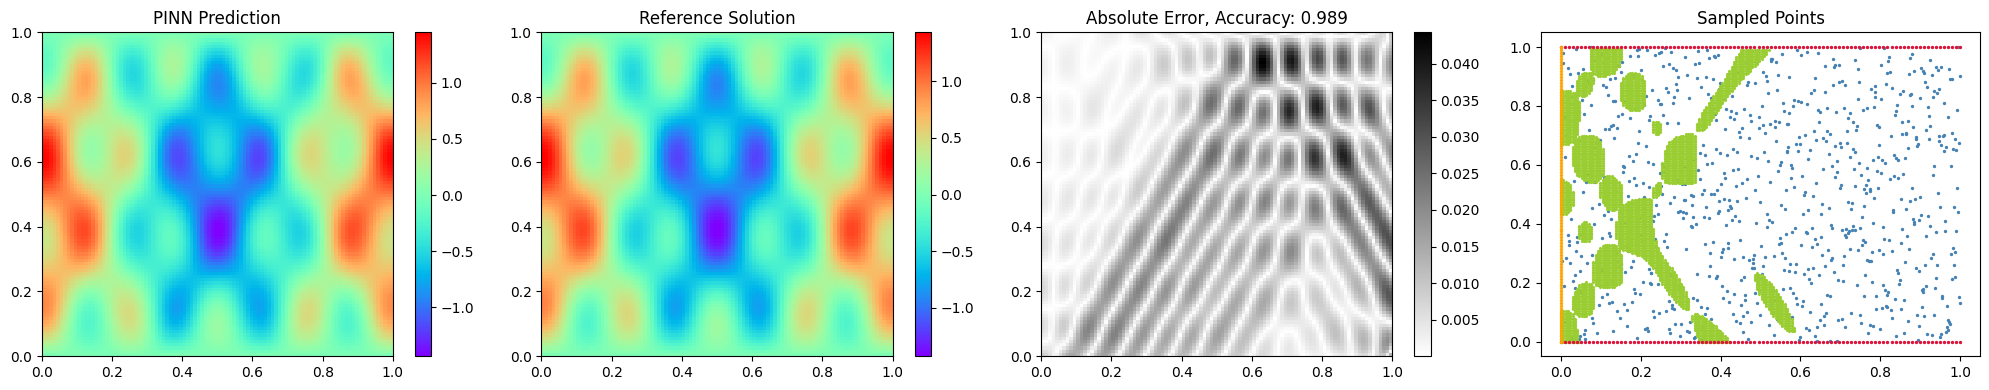

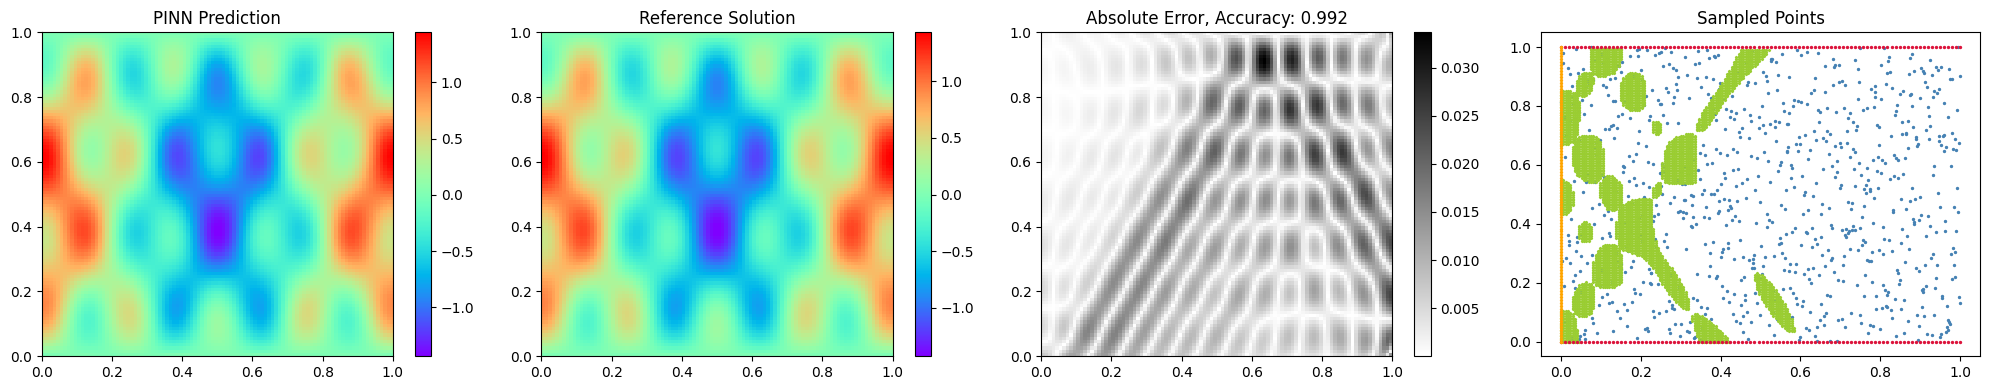

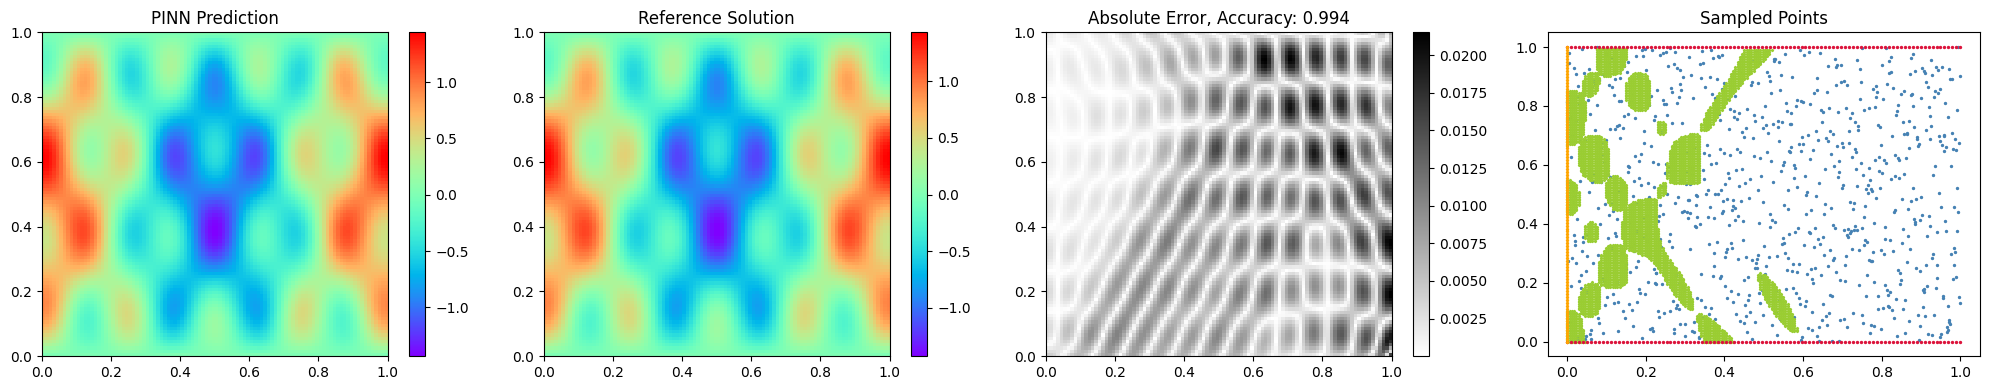

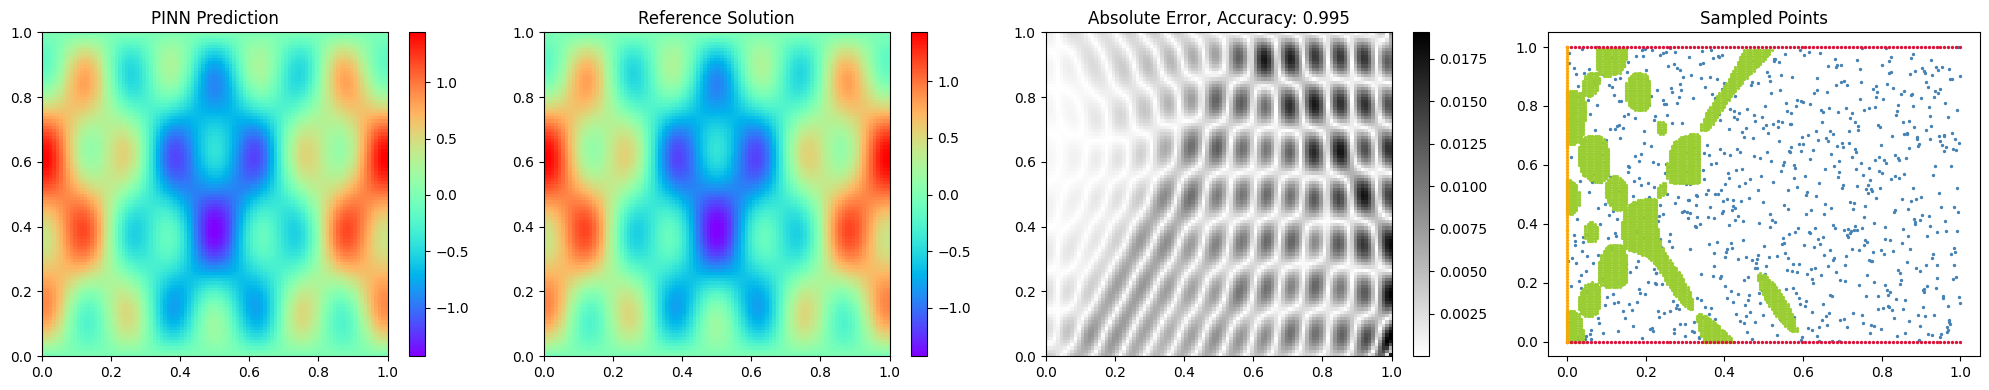

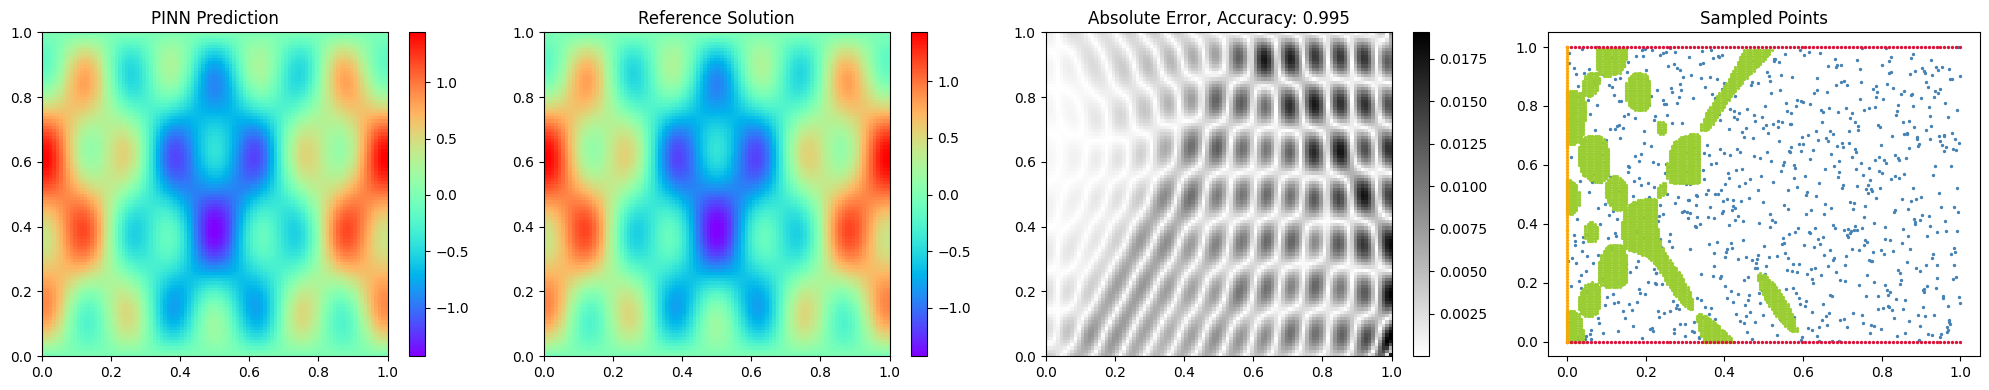

In [19]:
optimizer_lbfgs = torch.optim.LBFGS(model_wave.parameters(), lr=1, max_iter=10000, max_eval=None, history_size=100, tolerance_grad=1e-8, tolerance_change=1e-8, line_search_fn='strong_wolfe')

iteration = 0
def closure():
    global iteration        
    global ic_weight, bc_weight, pde_weight, ic_neumann_weight
    optimizer_lbfgs.zero_grad()
    pde_residual = model_wave.pde_residual(x_dom, t_dom)
    pde_loss = loss_fn(pde_residual, torch.zeros_like(pde_residual))
    bc_forward = model_wave.net_u(x_bc, t_bc)
    bc_loss = loss_fn(bc_forward, torch.zeros_like(bc_forward))
    ic_neumann_res = model_wave.u_t_func(x_ic, t_ic)
    ic_neumann_loss = loss_fn(ic_neumann_res, torch.zeros_like(ic_neumann_res))
    ic_forward = model_wave.net_u(x_ic, t_ic)
    ic_real = ic_func(x_ic).detach()
    ic_loss = loss_fn(ic_forward, ic_real)

    total_loss = ic_weight * ic_loss \
    + bc_weight * bc_loss \
    + pde_weight * pde_loss \
    + ic_neumann_weight * ic_neumann_loss
        

    if iteration % WEIGHT_UPDATE_INTERVAL == 0:
        print(f"Iteration {iteration}: pde_loss = {pde_loss.item():.4e}, ic_loss = {ic_loss.item():.4e}, bc_loss = {bc_loss.item():.4e}, ic_neumann_loss = {ic_neumann_loss.item():.4e},  Loss = {total_loss.item():.4e}")
        # Calculate NTK-based adaptive weights
        ntk_weights = model_wave.calculate_adaptive_weights(
            [pde_residual, ic_forward, bc_forward, ic_neumann_res],
            sampling_strategy='random',
            batch_size=NTK_BATCH_SIZE,
            return_info=False
        )
        pde_weight, ic_weight, bc_weight, ic_neumann_weight = ntk_weights

        print(f"Iteration {iteration}, "
            f"ic_weig: {ic_weight:.4e}, "
            f"bc_weig: {bc_weight:.4e}, "
            f"pde_weigt: {pde_weight:.4e}, "
            f"ic_neu_weig: {ic_neumann_weight:.4e}")
    
        model_wave.evaluate(dom_points, ic_points, bc_points, adaptive_points)
        

    total_loss.backward()
    iteration += 1
    return total_loss

optimizer_lbfgs.step(closure)
model_wave.evaluate(dom_points, ic_points, bc_points, adaptive_points)


### References

- Aditi S. Krishnapriyan, Amir Gholami, Shandian Zhe, Robert M. Kirby, Michael W. Mahoney. (2021). Characterizing possible failure modes in physics-informed neural networks. 35th Conference on Neural Information Processing Systems. https://arxiv.org/abs/2109.01050

- Chenxi Wu, Min Zhu, Qinyang Tan, Yadhu Kartha, & Lu Lu. (2023). A comprehensive study of non-adaptive and residual-based adaptive sampling for physics-informed neural networks. Computer Methods in Applied Mechanics and Engineering. https://arxiv.org/abs/2207.10289

- Sifan Wang, Shyam Sankaran, Hanwen Wang, & Paris Perdikaris. (2023). An Expert's Guide to Training Physics-informed Neural Networks. https://arxiv.org/abs/2308.08468

- Nanxi Chen, Sergio Lucarini, Rujin Ma, Airong Chen, & Chuanjie Cui. (2025). PF-PINNs: Physics-informed neural networks for solving coupled Allen-Cahn and Cahn-Hilliard phase field equations. Journal of Computational Physics. https://doi.org/10.1016/j.jcp.2025.113843

